In [18]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
import datetime
import concurrent.futures
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import threading


In [23]:

from utlis.sync_utlis.sync_df_utlis import find_calib_file
from utlis.scan_engine_utlis.scan_engine_utlis import (
    read_failed_paths,
    match_date_pattern,
    assign_status_codes,
)
from scan_engine.status_fields_config_oct3v1 import STATUS_FIELDS_CONFIG

# Import functions from utils.py
from utlis.scan_engine_utlis.scan_log_utlis import (
    load_scan_log,
    save_scan_log,
    clean_scan_log,
    update_scan_log,
    get_folders_to_scan
)

def scan_folder(folder_name, base_folder, failed_paths, config, rec_files_to_scan):
    folder_path = os.path.join(base_folder, folder_name)
    rec_files_data = []  # To store rec files and their status
    calib_files = []  # To store calibration files

    # Check for calibration files starting with 'calib'
    for file_name in os.listdir(folder_path):
        if file_name.startswith("calib"):
            calib_files.append(file_name)

    # Traverse subfolders within this folder
    for subfolder_name in rec_files_to_scan:
        subfolder_path = os.path.join(folder_path, subfolder_name)

        # Check for subfolders starting with a digit (rec folders)
        if os.path.isdir(subfolder_path) and subfolder_name[0].isdigit():
            # Find calibration file for each subfolder
            calib_file = find_calib_file(subfolder_path)

            # Assign status codes dynamically based on the config
            rec_file_data = assign_status_codes(
                folder_name, subfolder_path, calib_file, failed_paths, config
            )

            rec_file_data['rec_file'] = subfolder_name  # Add rec_file to the data
            # Add date-time for update and some future
            rec_file_data['scan_time'] = datetime.datetime.now().isoformat()

            rec_files_data.append(rec_file_data)

    return {
        'date_folder': folder_name,
        'calib_files': calib_files,  # Store the calibration files under date_folder level
        'rec_files_data': rec_files_data  # Each rec file with its status fields
    }

def log_folder_to_parquet_sep(base_folder, failed_paths_file, config, force_rescan_rec_files=None, rescan_threshold_days=7):
    """Log folders and save Parquet in subfolders with partial scan support."""

    # Paths for scan log
    scan_log_path = os.path.join(base_folder, 'paret', 'scan_log.csv')

    # Load or initialize the scan log
    scan_log_df = load_scan_log(scan_log_path)

    # Read manually inputted failed paths
    failed_paths = read_failed_paths(failed_paths_file) if failed_paths_file else set()

    # Forced rescans
    # force_rescan_rec_files = [
    #     # ('2023-10-01', '001'),
    #     # ('2023-10-02', '002'),
    #     # Add more as needed
    # ]
    # force_rescan_rec_files_set = set(force_rescan_rec_files)
    
    if force_rescan_rec_files is None:
        force_rescan_rec_files = []
    force_rescan_rec_files_set = set(force_rescan_rec_files)



    # Rescan threshold
    # rescan_threshold_days = 7

    # Determine folders to scan
    folders_to_scan = get_folders_to_scan(base_folder, scan_log_df, rescan_threshold_days, force_rescan_rec_files_set)

    if not folders_to_scan:
        print("No new or modified folders to scan.")
        return

    # Use ThreadPoolExecutor for parallel folder scanning
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for date_folder, rec_files_to_scan in folders_to_scan.items():
            futures.append(
                executor.submit(
                    scan_folder,
                    date_folder,
                    base_folder,
                    failed_paths,
                    config,
                    rec_files_to_scan
                )
            )

        for future in concurrent.futures.as_completed(futures):
            folder_log = future.result()
            date_folder = folder_log['date_folder']
            calib_files = folder_log.get('calib_files', [])

            # Ensure 'calib_files' is always a list of strings
            calib_files = [str(f) for f in calib_files] if calib_files else []

            # Process and save each experiment's log separately
            for rec_file_data in folder_log['rec_files_data']:
                rec_file = rec_file_data['rec_file']
                subfolder_save_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

                # Ensure the experiment/rec_file folder exists
                os.makedirs(os.path.dirname(subfolder_save_path), exist_ok=True)

                # Add 'date_folder' and 'calib_files' to rec_file_data
                rec_file_data['date_folder'] = date_folder
                rec_file_data['calib_files'] = calib_files

                # Dynamically ensure all relevant columns are strings based on config
                status_columns = list(config.keys())
                df = pd.DataFrame([rec_file_data])
                df[status_columns] = df[status_columns].astype(str)

                # Convert the data into a DataFrame and save the Parquet file
                table = pa.Table.from_pandas(df)
                pq.write_table(table, subfolder_save_path)

                print(f"Log for {rec_file} saved at {subfolder_save_path}")

                # Update the scan log
                scan_log_df = update_scan_log(scan_log_df, date_folder, rec_file)

    # Clean up the scan log
    scan_log_df = clean_scan_log(scan_log_df, base_folder)

    # Save the updated scan log
    save_scan_log(scan_log_df, scan_log_path)

if __name__ == "__main__":
    base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1"  # Replace with your base folder
    # save_path = os.path.join(base_folder, 'paret')
    failed_paths_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/sync_failed.txt'  # File containing failed paths


    force_rescan_rec_files = [
        # ('2023-10-01', '001'),
        # ('2023-10-02', '002'),
        # Add more as needed
    ]
    rescan_threshold_days = 0.0001 # 7 days, but guess if i mess up i can just change it to automatically rescan all, smile... #0.1

    log_folder_to_parquet_sep(base_folder, failed_paths_file, STATUS_FIELDS_CONFIG,
                              force_rescan_rec_files=force_rescan_rec_files,
                              rescan_threshold_days=rescan_threshold_days)


Log for 2social_mini_0605pmc_single_15_38 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_30/2social_mini_0605pmc_single_15_38/folder_log.parquet
Log for 2social_mini_0605pmc_single_15_18 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_30/2social_mini_0605pmc_single_15_18/folder_log.parquet
Log for 2social_mini_0605pmc_single_15_00 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_30/2social_mini_0605pmc_single_15_00/folder_log.parquet
Log for 20241015pmcr2_AO_12_52 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52/folder_log.parquet
Log for 2social_mini_20241015pmcr2_single_AO_13_24 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_07/2social_mini_20241015pmcr2_single_AO_13_24/folder_log.parquet
Log for 20241015pmcr1_AO_14_52 saved at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_07/20241015pmcr1_AO_14_52/folder_log.parquet
Log for 2social_mini_20240819V1r1_femalebleach_1

In [24]:
sys.path.append(os.path.abspath('../..'))
from utlis.scan_engine_utlis.scan_engine_utlis import read_all_parquet_files
base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1"
all_df = read_all_parquet_files(base_folder)

In [9]:
all_df

pyarrow.Table
mir_generate_param: string
sync: string
dropf_handle: string
com: string
social: string
miniscope: string
test: string
after_oxytocin: string
before_oxytocin: string
rec_file: string
scan_time: string
date_folder: string
calib_files: list<element: string>
  child 0, element: string
----
mir_generate_param: [["1"],["1"],...,["0"],["0"]]
sync: [["1"],["1"],...,["0"],["0"]]
dropf_handle: [["0"],["0"],...,["0"],["0"]]
com: [["0"],["0"],...,["0"],["0"]]
social: [["0"],["0"],...,["0"],["1"]]
miniscope: [["0"],["0"],...,["0"],["1"]]
test: [["0"],["0"],...,["0"],["0"]]
after_oxytocin: [["0"],["0"],...,["0"],["0"]]
before_oxytocin: [["0"],["0"],...,["0"],["0"]]
rec_file: [["20240707-PMC-r1"],["20240819-V1-r2"],...,["20241015pmcr2_AO_12_52"],["2social_mini_20241015pmcr2_single_AO_13_24"]]
...

In [10]:
# import pyarrow.compute as pc
# table = all_df #combined_df
# # Filter mir_generate_param == 0 and sync != 3
# filter_mask = pc.and_(
#     pc.equal(table['social'], '1'),
#     pc.not_equal(table['sync'], '3')
# )

# # Apply the filter and print the results
# filtered_table = table.filter(filter_mask)

# # Print each row of the filtered table
# print(filtered_table.to_pandas())  # This will display the filtered data in a familiar pandas-like format


   mir_generate_param sync dropf_handle com social miniscope test  \
0                   1    1            0   0      1         0    1   
1                   1    1            0   0      1         0    1   
2                   1    1            0   0      1         0    1   
3                   1    1            0   0      1         1    0   
4                   1    1            0   0      1         1    0   
5                   1    1            0   0      1         1    0   
6                   1    1            0   0      1         1    0   
7                   1    1            0   0      1         1    0   
8                   1    1            0   0      1         1    0   
9                   1    1            0   0      1         1    0   
10                  1    1            0   0      1         1    0   
11                  1    1            0   0      1         1    0   
12                  1    1            0   0      1         1    0   
13                  1    1        

In [4]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['mir_generate_param'], '0'),
    pc.not_equal(table['sync'], '3')
)

# Apply the filter and print the results
filtered_table = table.filter(filter_mask)

# Print each row of the filtered table
print(filtered_table.to_pandas())  # This will display the filtered data in a familiar pandas-like format


  mir_generate_param sync dropf_handle com social miniscope test  \
0                  0    0            0   0      0         0    1   
1                  0    0            0   0      0         0    1   
2                  0    0            0   0      0         0    1   

  after_oxytocin before_oxytocin dannce  \
0              0               0      0   
1              0               0      0   
2              0               0      0   

                                         rec_file                   scan_time  \
0          20240910v1r_cricket_cyliner_test_16_17  2024-11-13T20:22:15.421678   
1          240605pmc_righthole_acrylic_test_14_55  2024-11-13T20:22:15.500173   
2  240605pmc_righthole_cricket_acrylic_test_15_05  2024-11-13T20:22:15.502182   

  date_folder                    calib_files  
0  2024_11_13  [calib_before, calib_acrylic]  
1  2024_11_13  [calib_before, calib_acrylic]  
2  2024_11_13  [calib_before, calib_acrylic]  


In [9]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.exe_engine_utlis.mir_generate_param_modu import mir_generate_param_z

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder)
    calib_path = rec_file_data['calib_path'] if 'calib_path' in rec_file_data else os.path.join(combined_path, 'calib_before') #calib_before*
    calib_path = os.path.join(base_folder, date_folder, calib_path)
    if not calib_path:  # Check for empty or None calib_path
        print(f'No calib folder found. Aborting. {combined_path}/{rec_file}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'

    # Call your processing function
    ssssta = mir_generate_param_z(combined_path, calib_path, rec_file, output_file)
    print("mir_generate_param ran successfully.")

    # After processing, update the status in the specific Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    # Load the existing Parquet file
    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()  # Convert to pandas for easier manipulation
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return

    if ssssta is True:
        # Update the status field (assuming 'sync' is the column)
        df['mir_generate_param'] = '1'  # Set status to '1' for processed

        # Add scan_time (or other updates)
        df['scan_time'] = datetime.datetime.now().isoformat()

        # Write the updated DataFrame back to the Parquet file
        updated_table = pa.Table.from_pandas(df)
        pq.write_table(updated_table, parquet_file_path)

        print(f"Updated Parquet file at {parquet_file_path} with new status.")
    else:
        print(f'processed failed. please check {combined_path}/{rec_file}')

# Function to handle sequential processing and status updates
def sequential_process_and_update(filtered_table, base_folder):
    # Convert PyArrow table to pandas DataFrame
    filtered_df = filtered_table.to_pandas()

    # Process each row sequentially
    for row in filtered_df.itertuples(index=False):
        try:
            process_unit_and_update_status(row._asdict(), base_folder)
        except Exception as e:
            print(f"Error in processing: {e}")

# Example function call
# filtered_table = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table, base_folder)


Found 6 calibration files.
Frame count: 27300
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/calib_before/hires_cam1_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/calib_before/hires_cam2_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/calib_before/hires_cam3_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/calib_before/hires_cam4_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/calib_before/hires_cam5_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/calib_before/hires_cam6_params.mat
Data saved to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17/2024_11_13_20240910v1r_cricket_cyliner_test_16_17_calib_before_label3d_dannce.mat
mir_generate_param ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cric

In [6]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['mir_generate_param'], '1'),
    # pc.not_equal(table['sync'], '3'),
    pc.equal(table['sync'], '0')
)

# Apply the filter and print the results
filtered_table_for_sync = table.filter(filter_mask) # seems that one can just be here. other wise filter mask or something.

# Print each row of the filtered table
print(filtered_table_for_sync.to_pandas())  # This will display the filtered data in a familiar pandas-like format

Empty DataFrame
Columns: [mir_generate_param, sync, dropf_handle, com, social, miniscope, test, after_oxytocin, before_oxytocin, dannce, rec_file, scan_time, date_folder, calib_files]
Index: []


In [17]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import process_sync

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file sequentially
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder, rec_file)
    calib_path = rec_file_data.get('calib_path', os.path.join(base_folder, 'calib_before'))
    
    if not calib_path:
        print(f'No calib folder found. Aborting. {combined_path}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'
    print(f"Processing: {combined_path}")
    
    # Call the sync processing function
    sync_status = process_sync(combined_path, threshold=2, max_frames=300)
    if sync_status is True:
        print("Sync ran successfully.")
    else:
        print(f"please mannually process {combined_path}")

    # Update the status in the Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return
    
    # status = '1' if sync_status else '3'
    status = '3' if not sync_status else '1'
    if status == '3':
        print(f"Failed processing: {combined_path}, status set to 3.")
    
    # Update status and scan_time
    df['sync'] = status
    df['scan_time'] = datetime.datetime.now().isoformat()

    # Write back to the Parquet file
    updated_table = pa.Table.from_pandas(df)
    pq.write_table(updated_table, parquet_file_path)
    print(f"Updated Parquet file at {parquet_file_path} with new status.")
   
# Sequentially process and update the status for each rec_file
def sequential_process_and_update(filtered_table, base_folder):
    filtered_df = filtered_table.to_pandas()
    
    for _, row in filtered_df.iterrows():
        process_unit_and_update_status(row.to_dict(), base_folder)

# Example function call
# filtered_table_for_sync = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table_for_sync, base_folder)


Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17


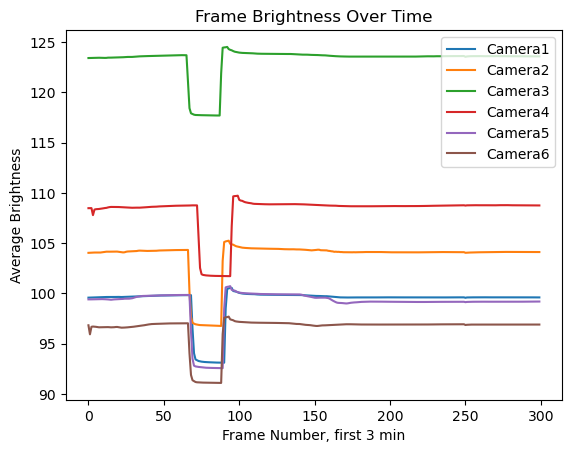

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17: {'Camera1': [69, 70], 'Camera2': [67, 68], 'Camera3': [66, 67], 'Camera4': [73, 74], 'Camera5': [68, 69], 'Camera6': [67, 68]}
Processed drop frames: {'Camera1': 70, 'Camera2': 68, 'Camera3': 67, 'Camera4': 74, 'Camera5': 69, 'Camera6': 68}
67
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17/df_synced_20240910v1r_cricket_cyliner_test_16_17_2024_11_13_20240910v1r_cricket_cyliner_test_16_17_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17/prev_calib
Sync ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20

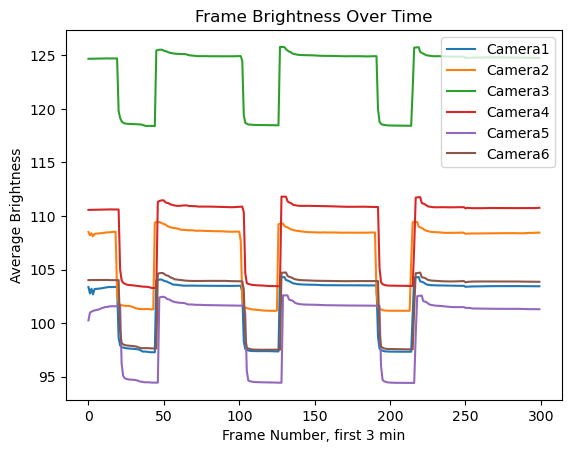

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55: {'Camera1': [20, 103, 192], 'Camera2': [19, 102, 191], 'Camera3': [20, 103, 192], 'Camera4': [21, 104, 193], 'Camera5': [22, 105, 194], 'Camera6': [21, 104, 193]}
Processed drop frames: {'Camera1': 20, 'Camera2': 19, 'Camera3': 20, 'Camera4': 21, 'Camera5': 22, 'Camera6': 21}
19
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55/df_synced_240605pmc_righthole_acrylic_test_14_55_2024_11_13_240605pmc_righthole_acrylic_test_14_55_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55
Error during alignment: Destination path '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55/prev_calib/2024_11_13_240605pmc_righthole_acrylic_test_14_55_calib_before

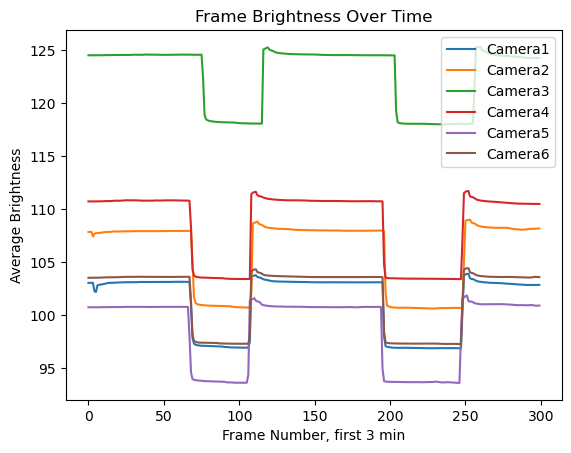

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05: {'Camera1': [68, 69, 196], 'Camera2': [69, 70, 197], 'Camera3': [76, 77, 204], 'Camera4': [68, 69, 196], 'Camera5': [67, 68, 195], 'Camera6': [68, 69, 196]}
Processed drop frames: {'Camera1': 69, 'Camera2': 70, 'Camera3': 77, 'Camera4': 69, 'Camera5': 68, 'Camera6': 69}
68
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05/df_synced_240605pmc_righthole_cricket_acrylic_test_15_05_2024_11_13_240605pmc_righthole_cricket_acrylic_test_15_05_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05
Moved prior calibration file to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05/prev_calib
Sync ran successfully.
Updated

In [10]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import process_sync

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file sequentially
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder, rec_file)
    calib_path = rec_file_data.get('calib_path', os.path.join(base_folder, 'calib_before'))
    
    if not calib_path:
        print(f'No calib folder found. Aborting. {combined_path}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'
    print(f"Processing: {combined_path}")
    
    # Call the sync processing function
    sync_status = process_sync(combined_path, threshold=2, max_frames=300)
    if sync_status is True:
        print("Sync ran successfully.")
    else:
        print(f"please mannually process {combined_path}")

    # Update the status in the Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return
    
    # status = '1' if sync_status else '3'
    status = '3' if not sync_status else '1'
    if status == '3':
        print(f"Failed processing: {combined_path}, status set to 3.")
    
    # Update status and scan_time
    df['sync'] = status
    df['scan_time'] = datetime.datetime.now().isoformat()

    # Write back to the Parquet file
    updated_table = pa.Table.from_pandas(df)
    pq.write_table(updated_table, parquet_file_path)
    print(f"Updated Parquet file at {parquet_file_path} with new status.")
   
# Sequentially process and update the status for each rec_file
def sequential_process_and_update(filtered_table, base_folder):
    filtered_df = filtered_table.to_pandas()
    
    for _, row in filtered_df.iterrows():
        process_unit_and_update_status(row.to_dict(), base_folder)

# Example function call
# filtered_table_for_sync = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table, base_folder)


In [ ]:
# if sync fail, this is used to delete all synced files...
# import os
# import concurrent.futures

# # Function to delete all files ending with '_label3d_dannce.mat' in the specified folder
# def delete_label3d_files_in_folder(rec_file_data, base_folder):
#     date_folder = rec_file_data['date_folder']
#     rec_file = rec_file_data['rec_file']
    
#     # Generate the combined path
#     combined_path = os.path.join(base_folder, date_folder, rec_file)
    
#     # Check if the folder exists
#     if not os.path.exists(combined_path):
#         print(f"Folder not found: {combined_path}")
#         return
    
#     # Find and delete all files ending with '_label3d_dannce.mat'
#     for file_name in os.listdir(combined_path):
#         if file_name.endswith('_label3d_dannce.mat'):
#             file_path = os.path.join(combined_path, file_name)
#             os.remove(file_path)
#             print(f"Deleted file: {file_path}")

# # Function to handle parallel deletion using filtered_table
# def parallel_delete_label3d_files(filtered_table, base_folder):
#     # Convert PyArrow table to pandas DataFrame
#     filtered_df = filtered_table.to_pandas()

#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = [
#             executor.submit(delete_label3d_files_in_folder, row._asdict(), base_folder)
#             for row in filtered_df.itertuples(index=False)
#         ]
        
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 future.result()  # Handle any exceptions
#             except Exception as e:
#                 print(f"Error during deletion: {e}")

# # Example function call
# # filtered_table = [...]  # Your filtered PyArrow table here
# # base_folder = '/path/to/your/base_folder'
# parallel_delete_label3d_files(filtered_table_for_sync, base_folder)


In [12]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['sync'], '1'),
    pc.equal(table['date_folder'], '2024_11_13') #add trhe most recent here.
)

# Apply the filter and print the results
for_dh = table.filter(filter_mask)

# Print each row of the filtered table
print(for_dh.to_pandas())  # This will display the filtered data in a familiar pandas-like format


  mir_generate_param sync dropf_handle com social miniscope test  \
0                  0    0            0   0      0         0    1   
1                  0    0            0   0      0         0    1   
2                  0    0            0   0      0         0    1   

  after_oxytocin before_oxytocin dannce  \
0              0               0      0   
1              0               0      0   
2              0               0      0   

                                         rec_file                   scan_time  \
0          20240910v1r_cricket_cyliner_test_16_17  2024-11-13T20:22:15.421678   
1          240605pmc_righthole_acrylic_test_14_55  2024-11-13T20:22:15.500173   
2  240605pmc_righthole_cricket_acrylic_test_15_05  2024-11-13T20:22:15.502182   

  date_folder                    calib_files  
0  2024_11_13  [calib_before, calib_acrylic]  
1  2024_11_13  [calib_before, calib_acrylic]  
2  2024_11_13  [calib_before, calib_acrylic]  


In [13]:
from utlis.sync_utlis.dropf_handler import drop_frame_handler
records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_dh['date_folder'], for_dh['rec_file'])
]

# Iterate through the records and process each one sequentially
for record in records:
    base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
    print(base_path)
    drop_frame_handler(base_path)


/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17
Loaded frametimes for Camera1
Loaded frametimes for Camera2
Loaded frametimes for Camera3
Loaded frametimes for Camera4
Loaded frametimes for Camera5
Loaded frametimes for Camera6
Maximum shapes for each camera: {'Camera1': 27300, 'Camera2': 27300, 'Camera3': 27300, 'Camera4': 27300, 'Camera5': 27300, 'Camera6': 27300}
Cameras have consistent shapes. Skipping alignment.
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55
Loaded frametimes for Camera1
Loaded frametimes for Camera2
Loaded frametimes for Camera3
Loaded frametimes for Camera4
Loaded frametimes for Camera5
Loaded frametimes for Camera6
Maximum shapes for each camera: {'Camera1': 9000, 'Camera2': 9000, 'Camera3': 9000, 'Camera4': 9000, 'Camera5': 9000, 'Camera6': 9000}
Cameras have consistent shapes. Skipping alignment.
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/24060

In [7]:
# import pyarrow.compute as pc
# table = all_df #combined_df
# # Filter mir_generate_param == 0 and sync != 3
# filter_mask = pc.and_(
#     pc.equal(table['dropf_handle'], '1'),
#     pc.not_equal(table['com'], '1')
# )

# # Apply the filter and print the results
# for_com = table.filter(filter_mask)

# # Print each row of the filtered table
# print(for_com.to_pandas())  # This will display the filtered data in a familiar pandas-like format


  mir_generate_param sync dropf_handle com social miniscope test  \
0                  1    1            1   0      0         0    0   
1                  1    1            1   0      0         0    0   

  after_oxytocin before_oxytocin            rec_file  \
0              0               0        20240819V1r2   
1              0               0  20240916v1r1_16_35   

                    scan_time date_folder                        calib_files  
0  2024-11-07T21:28:50.199290  2024_10_03                     [calib_for_v1]  
1  2024-11-07T21:28:49.981486  2024_10_14  [calib_after_17_43, calib_before]  


In [36]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Filter dropf_handle == 1, com != 1, and social != 1
# filter_mask = pc.and_(
#     # pc.equal(table['dropf_handle'], '1'),
#     pc.not_equal(table['com'], '1'),
#     pc.not_equal(table['social'], '1')
# )

filter_mask = pc.and_(
    # pc.and_(
        # pc.not_equal(table['date_folder'], '2024_11_06'),
        
        # pc.and_(
        #     pc.not_equal(table['date_folder'], '2024_11_06'),
        #     # pc.and_(
        #     #     pc.not_equal(table['date_folder'], '2024_11_06'),
        #     #     pc.not_equal(table['date_folder'], '2024_09_18')
        #     # ),
        #     pc.not_equal(table['date_folder'], '2024_11_07')
        # ),
    pc.not_equal(table['com'], '1'),
    # ),
    # pc.not_equal(table['social'], '1')
    pc.and_(
        pc.not_equal(table['social'], '1'),
        # pc.equal(table['sync'], '1')
            # pc.not_equal(table['social'], '1')
        pc.and_(
            # pc.not_equal(table['dannce'], '1'),
            pc.not_equal(table['test'], '1'),
            pc.equal(table['sync'], '1')
    )
    )
)

# Apply the filter and print the results
for_com = table.filter(filter_mask)

# Print each row of the filtered table
print(for_com.to_pandas())  # Display the filtered data in a familiar pandas-like format


Empty DataFrame
Columns: [mir_generate_param, sync, dropf_handle, com, social, miniscope, test, after_oxytocin, before_oxytocin, rec_file, scan_time, date_folder, calib_files]
Index: []


In [3]:
table = all_df  # combined_df
# Filter dropf_handle == 1, com != 1, and social != 1
filter_mask = pc.and_(
    # pc.equal(table['dropf_handle'], '1'),
    # pc.not_equal(table['com'], '1'),
    # pc.not_equal(table['social'], '1')
    pc.equal(table['date_folder'], '2024_11_13'),
    pc.not_equal(table['com'], '1'),
)



# Apply the filter and print the results
for_com = table.filter(filter_mask)

# Print each row of the filtered table
print(for_com.to_pandas())  # Display the filtered data in a familiar pandas-like format

NameError: name 'all_df' is not defined

In [15]:
# for_com=for_com_vis

from concurrent.futures import ThreadPoolExecutor
import os

import subprocess

def get_num_running_jobs(user):
    result = subprocess.run(
        ['squeue', '-u', user, '-h', '-t', 'R'],
        stdout=subprocess.PIPE,
        text=True
    )
    lines = result.stdout.strip().split('\n')
    # Filter out empty lines
    running_jobs = [line for line in lines if line]
    return len(running_jobs)



slurm_launch_file = '/hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py'

def check_expdir(expdir):
    if not os.path.exists(expdir):
        print(f"Skipping: Experiment directory {expdir} does not exist")
        return None  # Return None or skip processing this directory
    return expdir


# Function to create the full expdir path and print the command for dry-run
def run_command(base_path, date_folder, rec_file, dry_run=True):
    expdir_path = os.path.join(base_path, date_folder, rec_file)
    
    # Check if the experiment directory exists before running the command
    if check_expdir(expdir_path) is None:
        return  # Skip this execution if the directory does not exist
    
    # command = f"python {slurm_launch_file} --expdir {expdir_path} --predict_com"
    command = f"conda run -n sdannce python {slurm_launch_file} --expdir {expdir_path} --predict_com --allow_overwrite" #--allow_overwrite

    if dry_run:
        print(f"[DRY-RUN] Command: {command}")
    else:
        print(f"Executing command: {command}")
        os.system(command)


# Extract relevant data from the filtered PyArrow Table `for_com`
base_path = base_folder #"/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Adjust this base path as needed
records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_com['date_folder'], for_com['rec_file'])
]

# Run in parallel with dry-run enabled for testing
# max_concurrent_jobs = 6 # chosing how mnay gpu to take, let's say maybe 4??? or 5... we're not urgent so.... this actually would not work because submitting jobs takes a second... so whatever...
user = 'lq53'

dry_run = False #True  # Set to False to execute commands
with ThreadPoolExecutor() as executor: #max_workers=max_concurrent_jobs
    futures = [
        executor.submit(run_command, base_path, record['date_folder'], record['rec_file'], dry_run)
        for record in records
    ]
# for record in records:
#     while True:
#         num_jobs = get_num_running_jobs(user)
#         if num_jobs < max_concurrent_jobs:
#             # Submit the job
#             run_command(base_path, record['date_folder'], record['rec_file'], dry_run)
#             break
#         else:
#             # Wait before checking again
#             time.sleep(30)  # Wait for 30 seconds before retrying


# print("Dry-run test complete. Review the printed commands.")


Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17 --predict_com --allow_overwrite
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05 --predict_com --allow_overwrite
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55 --predict_com --allow_overwrite
Specified a single expdir; running predictions ...
Running command:  cd /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55
dannce predict com /hpc/group/

In [17]:
# from concurrent.futures import ThreadPoolExecutor
# import os

# slurm_launch_file = '/hpc/group/tdunn/lq53/tianqing_pytorch_dannce/sdannce_scripts/slurm_launch_predict.py'

# def check_expdir(expdir):
#     if not os.path.exists(expdir):
#         print(f"Skipping: Experiment directory {expdir} does not exist")
#         return None  # Return None or skip processing this directory
#     return expdir


# # Function to create the full expdir path and print the command for dry-run
# def run_command(base_path, date_folder, rec_file, dry_run=True):
#     expdir_path = os.path.join(base_path, date_folder, rec_file)
    
#     # Check if the experiment directory exists before running the command
#     if check_expdir(expdir_path) is None:
#         return  # Skip this execution if the directory does not exist
    
#     # command = f"python {slurm_launch_file} --expdir {expdir_path} --predict_com"
#     command = f"conda run -n sdannce python {slurm_launch_file} --expdir {expdir_path} --predict_com"

#     if dry_run:
#         print(f"[DRY-RUN] Command: {command}")
#     else:
#         print(f"Executing command: {command}")
#         os.system(command)


# # Extract relevant data from the filtered PyArrow Table `for_com`
# base_path = base_folder #"/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Adjust this base path as needed
# records = [
#     {
#         'date_folder': date_folder.as_py(),  # Convert to string using as_py()
#         'rec_file': rec_file.as_py()         # Convert to string using as_py()
#     }
#     for date_folder, rec_file in zip(for_dh['date_folder'], for_dh['rec_file'])
# ]

# # Run in parallel with dry-run enabled for testing
# max_concurrent_jobs = 2 # chosing how mnay gpu to take, let's say maybe 4??? or 5... we're not urgent so...

# dry_run = False #True  # Set to False to execute commands
# # parallelly submission of jobs is just stupid....
# # with ThreadPoolExecutor(max_workers=max_concurrent_jobs) as executor:
# #     futures = [
# #         executor.submit(run_command, base_path, record['date_folder'], record['rec_file'], dry_run)
# #         for record in records
# #     ]


# # print("Dry-run test complete. Review the printed commands.")

Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/sdannce_scripts/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240707-PMC-r1 --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/sdannce_scripts/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240819-V1-r2 --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/sdannce_scripts/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240819_V1_r1 --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/sdannce_scripts/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240819_V1_r1_2 --predict_com
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing

In [3]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Filter dropf_handle == 1, com != 1, and social != 1
# filter_mask = pc.and_(
#     # pc.equal(table['dropf_handle'], '1'),
#     pc.not_equal(table['com'], '1'),
#     pc.not_equal(table['social'], '1')
# )

filter_mask = pc.and_(
    # pc.and_(
        # pc.not_equal(table['date_folder'], '2024_11_06'),
        
        # pc.and_(
        #     pc.not_equal(table['date_folder'], '2024_11_06'),
        #     # pc.and_(
        #     #     pc.not_equal(table['date_folder'], '2024_11_06'),
        #     #     pc.not_equal(table['date_folder'], '2024_09_18')
        #     # ),
        #     pc.not_equal(table['date_folder'], '2024_11_07')
        # ),
    pc.equal(table['com'], '1'),
    # ),
    # pc.not_equal(table['social'], '1')
    pc.and_(
        pc.not_equal(table['social'], '1'),
        pc.equal(table['date_folder'], '2024_11_13')
    )
)

# Apply the filter and print the results
for_com_vis = table.filter(filter_mask)

# Print each row of the filtered table
print(for_com_vis.to_pandas())  # Display the filtered data in a familiar pandas-like format


  mir_generate_param sync dropf_handle com social miniscope test  \
0                  1    1            0   1      0         0    1   
1                  1    1            0   1      0         0    1   

  after_oxytocin before_oxytocin dannce  \
0              0               0      0   
1              0               0      0   

                                         rec_file                   scan_time  \
0          240605pmc_righthole_acrylic_test_14_55  2024-11-14T14:13:27.899053   
1  240605pmc_righthole_cricket_acrylic_test_15_05  2024-11-14T14:13:27.902545   

  date_folder                    calib_files  
0  2024_11_13  [calib_before, calib_acrylic]  
1  2024_11_13  [calib_before, calib_acrylic]  


In [ ]:
# from utlis.vis_valid_utlis.com_trag_updated import plot_com_all

# plot_com_all() #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55


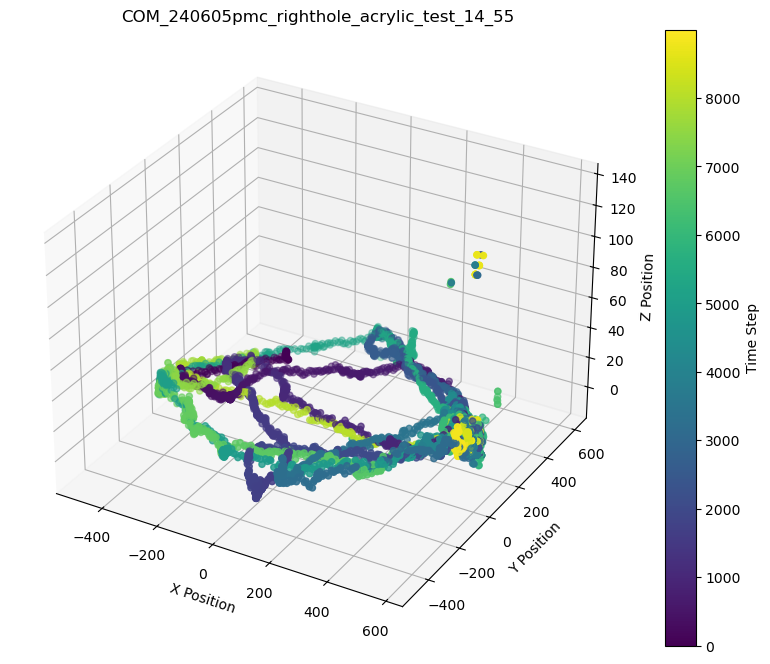

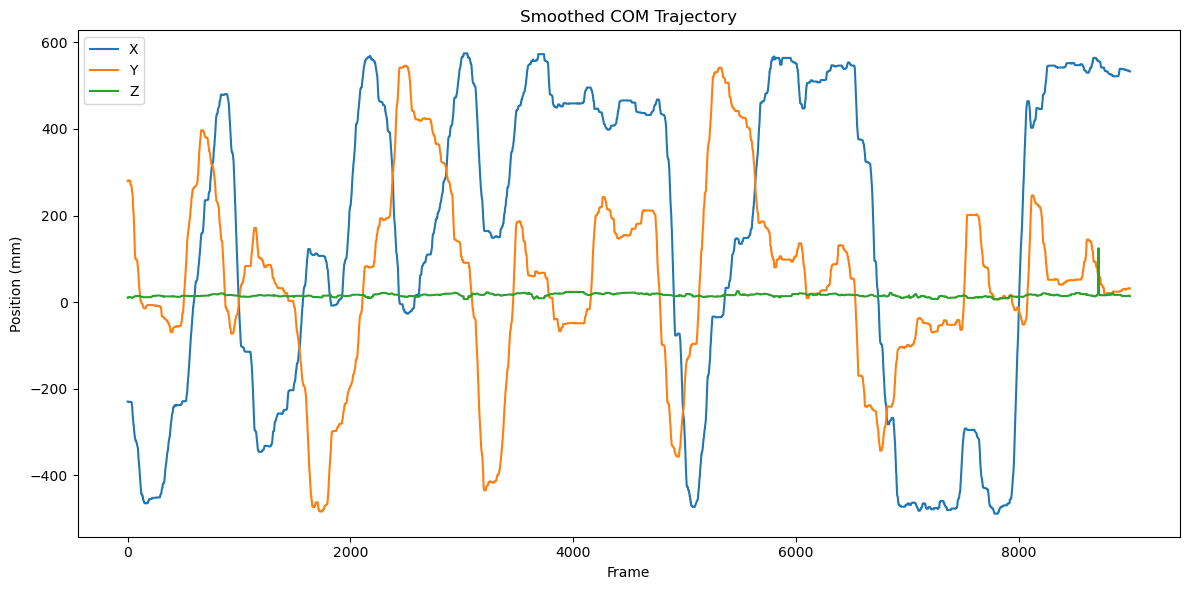

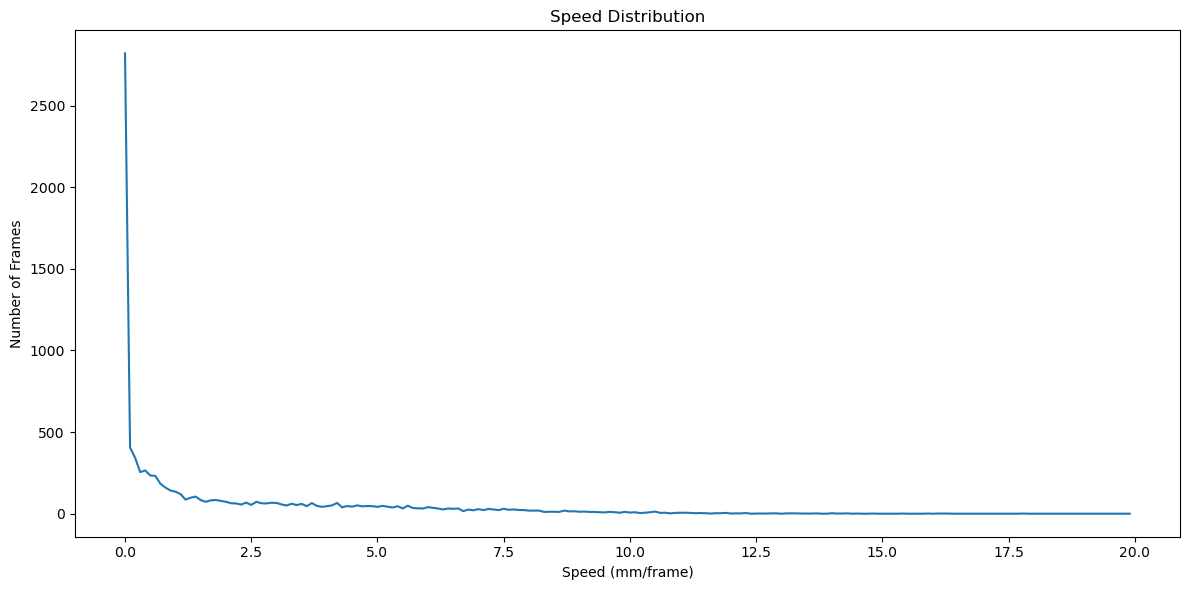

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55/COM/predict00/vis
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05
plotting com_traga for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05


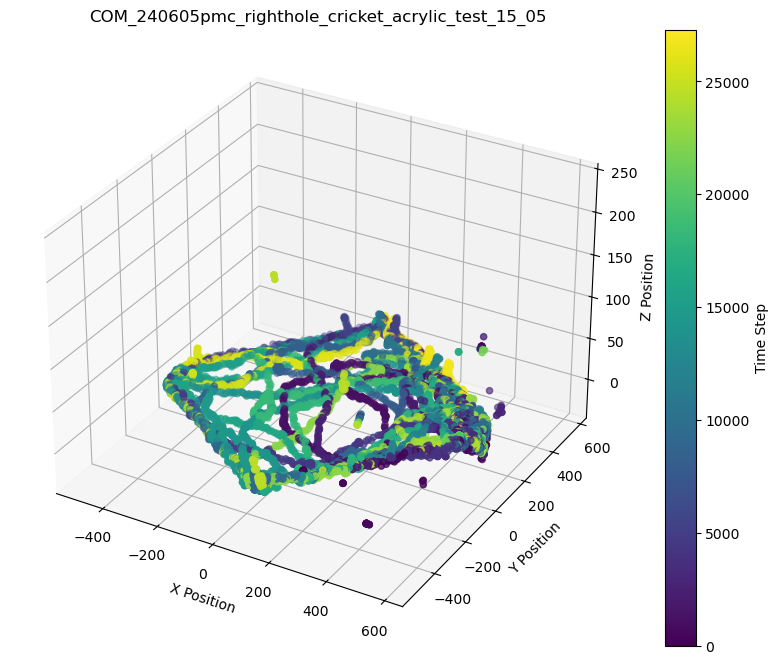

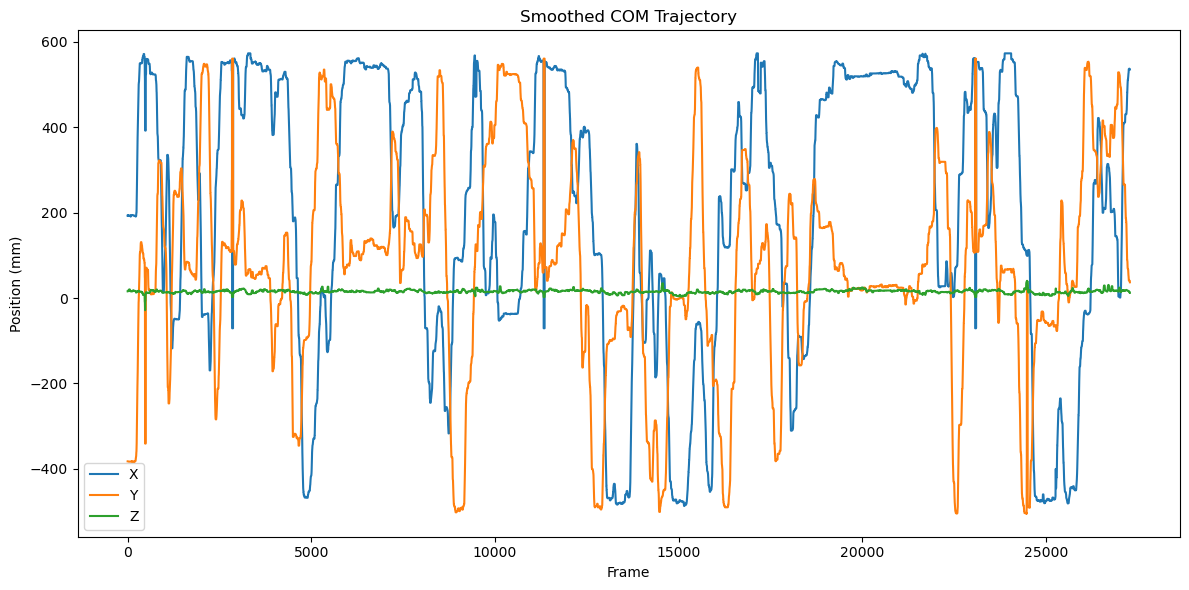

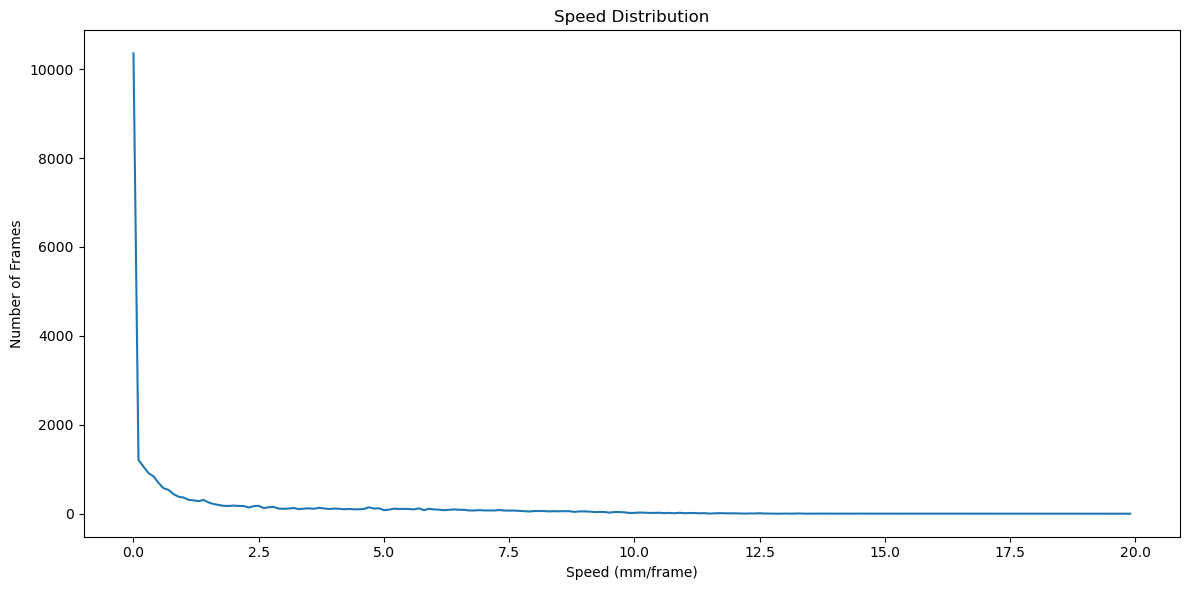

Analysis complete. Plots saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05/COM/predict00/vis


In [4]:
from utlis.vis_valid_utlis.com_trag_updated import plot_com_all

# Assume base_folder is defined elsewhere in your script
# base_folder = '/path/to/your/base/folder'

records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_com_vis['date_folder'], for_com_vis['rec_file'])
]

# Iterate through the records and process each one sequentially
for record in records:
    base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
    print(base_path)
    plot_com_all(base_path) #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False


In [25]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Filter dropf_handle == 1, com != 1, and social != 1
filter_mask = pc.and_(
    # pc.equal(table['dropf_handle'], '1'),
    pc.equal(table['com'], '1'),
    pc.not_equal(table['dannce'], '1'),
    # pc.not_equal(table['social'], '1')
    # pc.and_(
    #     pc.not_equal(table['dannce'], '1'),
    #     pc.not_equal(table['test'], '1'),
    #     # pc.equal(table['sync'], '1')
    # )
)

# filter_mask = pc.and_(
#     # pc.and_(
#         # pc.not_equal(table['date_folder'], '2024_11_06'),
        
#         # pc.and_(
#         #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     # pc.and_(
#         #     #     pc.not_equal(table['date_folder'], '2024_11_06'),
#         #     #     pc.not_equal(table['date_folder'], '2024_09_18')
#         #     # ),
#         #     pc.not_equal(table['date_folder'], '2024_11_07')
#         # ),
#     pc.equal(table['com'], '1'),
#     # ),
#     pc.not_equal(table['social'], '1')
#     # pc.and_(
#     #     pc.not_equal(table['social'], '1'),
#     #     pc.equal(table['sync'], '1')
#     # )
# )

# Apply the filter and print the results
for_dannce = table.filter(filter_mask) #filter_mask

# Print each row of the filtered table
print(for_dannce.to_pandas())  # Display the filtered data in a familiar pandas-like format


  mir_generate_param sync dropf_handle com social miniscope test  \
0                  1    1            1   1      0         0    0   
1                  1    1            1   1      0         0    0   

  after_oxytocin before_oxytocin dannce            rec_file  \
0              0               0      0        20240819V1r2   
1              0               0      0  20240916v1r1_16_35   

                    scan_time date_folder                        calib_files  
0  2024-11-15T13:24:55.031844  2024_10_03                     [calib_for_v1]  
1  2024-11-15T13:24:55.025299  2024_10_14  [calib_after_17_43, calib_before]  


In [17]:
# below is to exclude the bad com dir mannually, by inserting things in a txt file...


from concurrent.futures import ThreadPoolExecutor
import os

slurm_launch_file = '/hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py'

def check_expdir(expdir):
    if not os.path.exists(expdir):
        print(f"Skipping: Experiment directory {expdir} does not exist")
        return None  # Return None or skip processing this directory
    return expdir

# Function to create the full expdir path and print the command for dry-run
def run_command(base_path, date_folder, rec_file, partition='scavenger-gpu', dry_run=True):
    expdir_path = os.path.join(base_path, date_folder, rec_file)
    
    # Check if the experiment directory exists before running the command
    if check_expdir(expdir_path) is None:
        return  # Skip this execution if the directory does not exist
    
    command = f"conda run -n sdannce python {slurm_launch_file} --expdir {expdir_path} --predict_dannce --partition {partition}"  # --allow_overwrite removed by default.

    if dry_run:
        print(f"[DRY-RUN] Command: {command}")
    else:
        print(f"Executing command: {command}")
        os.system(command)

# Read the list of relative paths to skip from the .txt file
txt_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/1_point_com_rerun.txt'  # Update this to the path of your .txt file
rel_paths_to_skip = set()
with open(txt_file, 'r') as f:
    for line in f:
        rel_path = line.strip()
        if rel_path:
            rel_paths_to_skip.add(rel_path)

# print(rel_paths_to_skip)

# Extract relevant data from the filtered PyArrow Table `for_com_vis`
base_path = base_folder  # Ensure base_folder is defined
# base_path = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Adjust this base path as needed

records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_dannce['date_folder'], for_dannce['rec_file'])
]

# Run in parallel with dry-run enabled for testing
max_concurrent_jobs = 4  # Choose how many jobs to run in parallel

dry_run = False  # Set to False to execute commands

with ThreadPoolExecutor(max_workers=max_concurrent_jobs) as executor:
    futures = []
    futures = []
    for record in records:
        # Create the relative path (date_folder/rec_file)
        rel_path = os.path.join(record['date_folder'], record['rec_file'])
        expdir_path = os.path.join(base_path, rel_path)

        if expdir_path in rel_paths_to_skip:
            print(f"Skipping: {rel_path} is in the skip list")
            continue  # Skip this record if it's in the skip list

        # Submit the job to the executor
        futures.append(
            executor.submit(run_command, base_path, record['date_folder'], record['rec_file'], 'scavenger-gpu', dry_run)
        )


Skipping: 2024_10_03/20240819V1r2 is in the skip list
Skipping: 2024_10_14/20240916v1r1_16_35 is in the skip list
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1_21_05 --predict_dannce --partition scavenger-gpu
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240916V1r2 --predict_dannce --partition scavenger-gpu
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py --expdir /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241001PMCr2_15_07 --predict_dannce --partition scavenger-gpu
Executing command: conda run -n sdannce python /hpc/group/tdunn/lq53/tianqing_pytorch_dannce/dannce_/slurm_launch_predict.py -

In [21]:
import pyarrow.compute as pc
table = all_df  # combined_df

# Apply the filter and print the results
for_dannce_vis = table.filter(pc.equal(table['dannce'], '1')) #filter_mask

# Print each row of the filtered table
print(for_dannce_vis.to_pandas())  # Display the filtered data in a familiar pandas-like format


   mir_generate_param sync dropf_handle com social miniscope test  \
0                   1    1            0   1      0         0    0   
1                   1    1            0   1      0         0    0   
2                   1    1            0   1      0         0    0   
3                   1    1            0   1      0         0    0   
4                   1    1            0   1      0         0    0   
5                   1    1            0   1      0         0    0   
6                   1    1            0   1      0         0    0   
7                   1    1            0   1      0         0    0   
8                   1    1            0   1      0         0    0   
9                   1    1            1   1      0         0    0   
10                  1    1            0   1      0         0    0   
11                  1    1            0   1      0         0    0   
12                  1    1            0   1      0         0    0   
13                  1    1        

In [ ]:
# from useful_files.sophie_check_dannce_mir_modif import calculate_dis

# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.io as sio


# def dannce_valid(base_path):

#     # params_file_end = 'big_label3d_dannce.mat' # camera parameters
#     save_path = os.path.join(base_path, 'DANNCE/predict00', 'vis')
#     pred_mat = 'save_data_AVG.mat'
#     # Check if the savePath exists
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     temp_pred_mat = os.path.join(base_path, 'DANNCE/predict00',pred_mat)
#     # ground truth according to true labels
#     ground_truth_average = [19.18, 50.93, 10.59, 10.8]
#     ground_truth_std = [2.9, 8, 2.36, 2.48]
#     labels = ['BetweenEars', 'Trunk', 'LeftHind', 'RightHind']

#     # Check if the prediction file exists
#     if not os.path.exists(temp_pred_mat):
#         print(f"Prediction file '{pred_mat}' not found in '{base_path}'.")
#         return

#     # Load prediction data
#     try:
#         pre = sio.loadmat(temp_pred_mat)['pred']
#     except Exception as e:
#         print(f"Error loading prediction data from '{temp_pred_mat}': {e}")
#         return

#     # Calculate distances
#     pre_dis1 = calculate_dis(0, 1, pre)
#     pre_dis2 = calculate_dis(3, 5, pre)
#     pre_dis3 = calculate_dis(16, 17, pre)
#     pre_dis4 = calculate_dis(19, 20, pre)

#     # Compute averages and standard deviations, ignoring NaN values
#     pred_average = [
#         np.nanmean(pre_dis1),
#         np.nanmean(pre_dis2),
#         np.nanmean(pre_dis3),
#         np.nanmean(pre_dis4)
#     ]
#     pred_std = [
#         np.nanstd(pre_dis1),
#         np.nanstd(pre_dis2),
#         np.nanstd(pre_dis3),
#         np.nanstd(pre_dis4)
#     ]

#     # Plotting
#     size = 4
#     total_width, n = 0.8, 2
#     x = np.arange(size)
#     width = total_width / n
#     x_shifted = x - (total_width - width) / 2  # Adjust the x position for better alignment

#     plt.figure(figsize=(10, 6))
#     plt.bar(x_shifted, ground_truth_average, width=width, yerr=ground_truth_std, label='GroundTruth', capsize=5)
#     plt.bar(x_shifted + width, pred_average, width=width, yerr=pred_std, label='Prediction', capsize=5)
#     plt.xticks(x + width / 2, labels)
#     plt.xlabel('Segments')
#     plt.ylabel('Distance (mm)')
#     plt.title(os.path.basename(os.path.dirname(base_path)) +'_'+ os.path.basename(base_path))
#     plt.legend(loc='best')
#     plt.tight_layout()
    

#     # Save the plot
#     save_name = os.path.join(save_path, f"{os.path.basename(os.path.dirname(base_path))}_{os.path.basename(base_path)}.jpg")
#     try:
#         plt.savefig(save_name)
#         print(f"Plot saved as '{save_name}'.")
#     except Exception as e:
#         print(f"Error saving plot '{save_name}': {e}")
    
#     plt.show()
#     plt.close()

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240707-PMC-r1/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240819_V1_r1/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240819_V1_r1_2/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240819-V1-r2/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1_20_10/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1_21_40/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1_21_05/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1







Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1_20_10/DANNCE/predict00/vis/2024_10_04_20240819V1r1_20_10.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240819V1r1_21_05/DANNCE/predict00/vis/2024_10_04_20240819V1r1_21_05.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_09_18/20240707-PMC-r1/DANNC

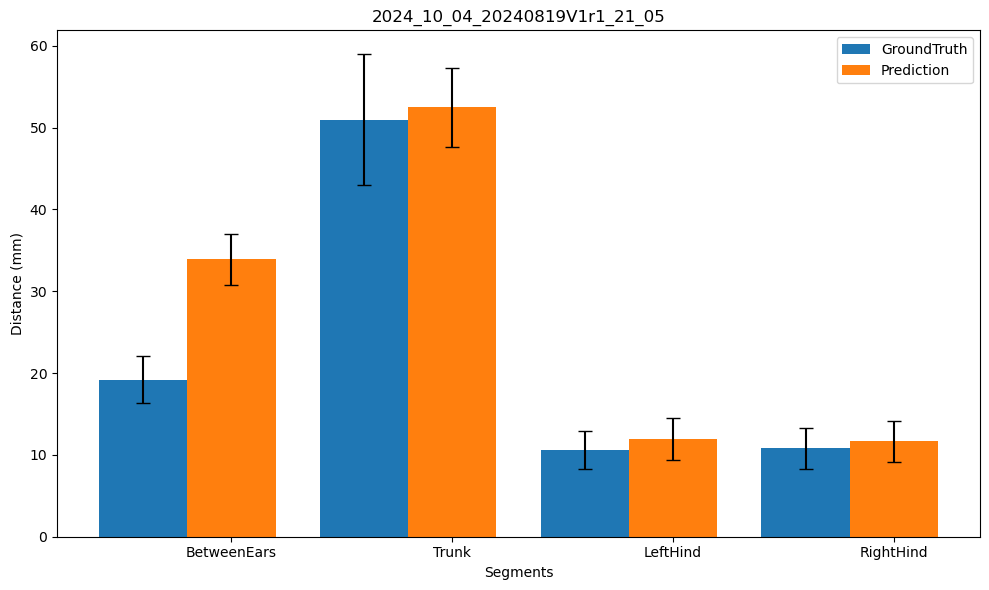

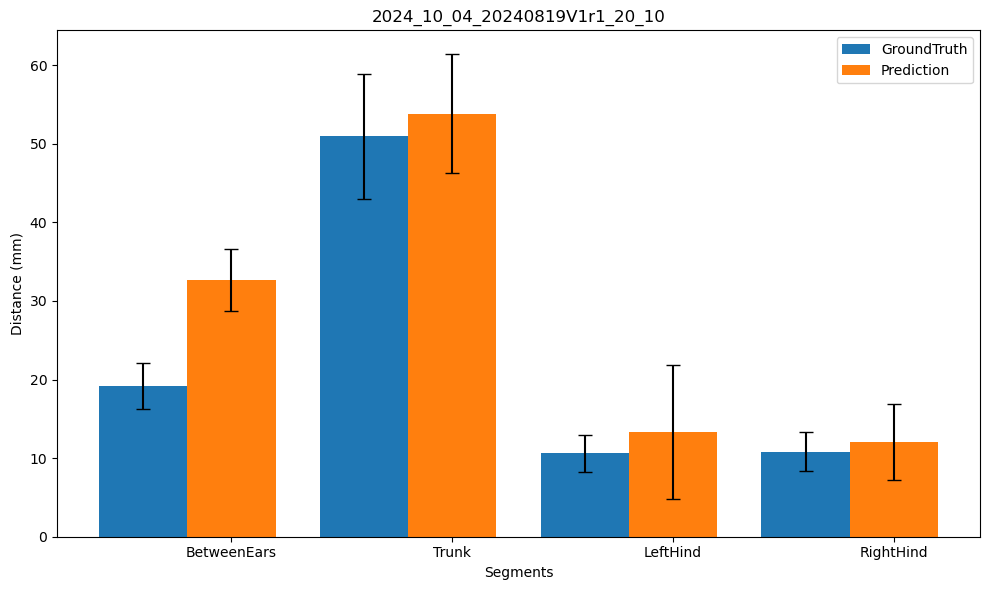

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240916V1r2
/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240916V1r1

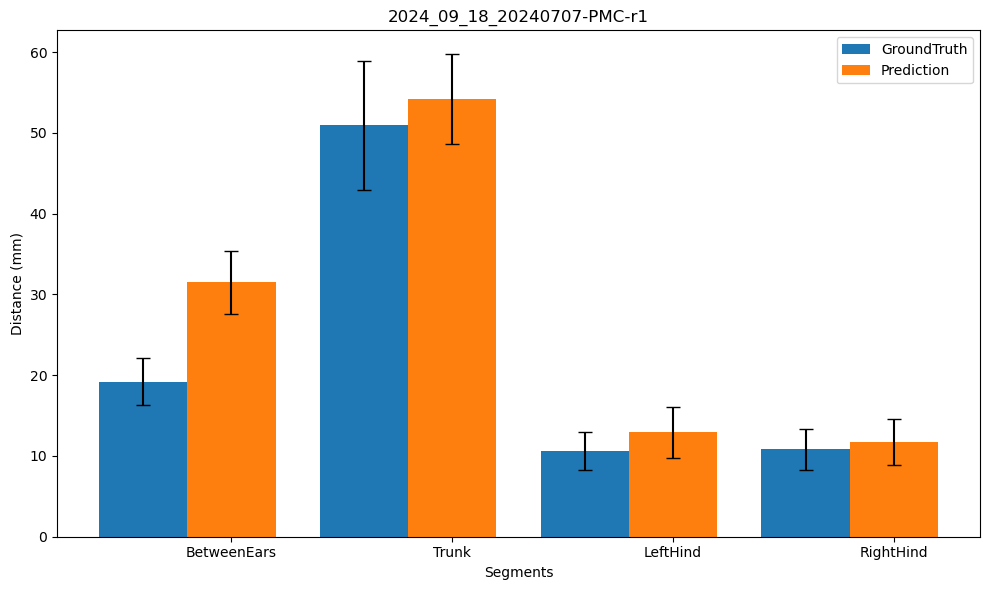


/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_07/20240916v1r1_15_05_30min


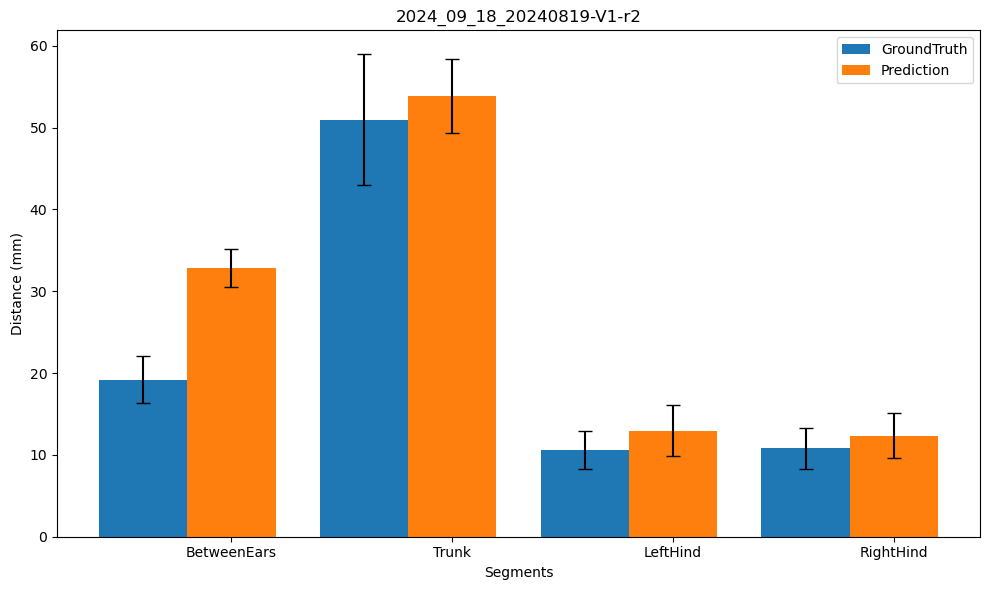

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_07/20240916v1r1_17_55


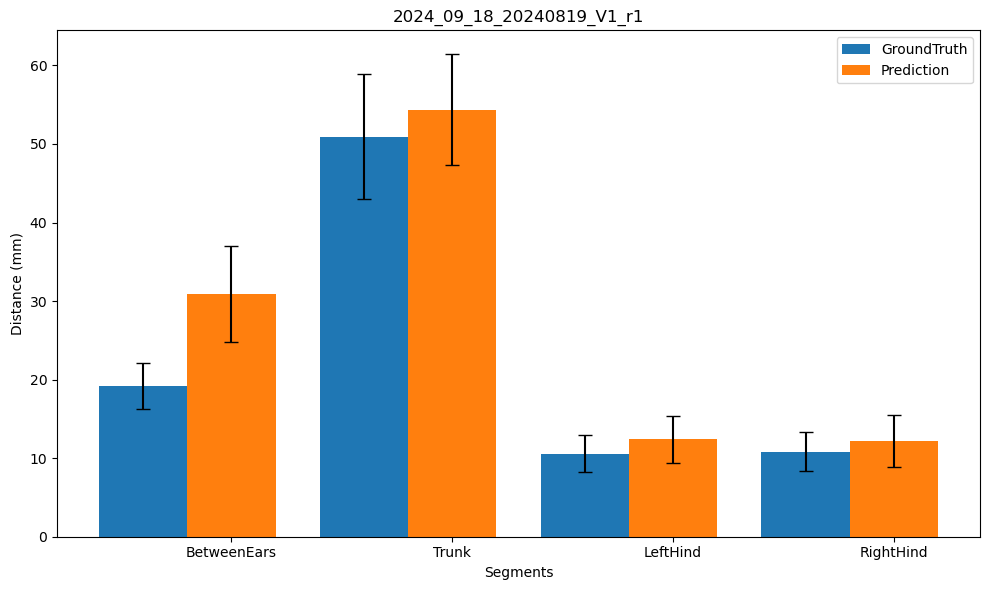

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_19_44

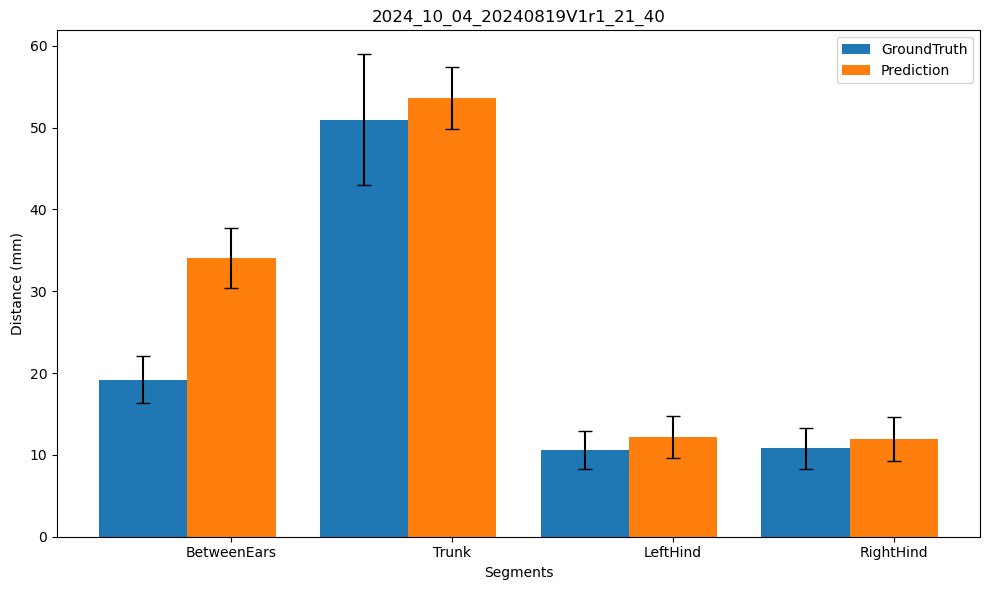

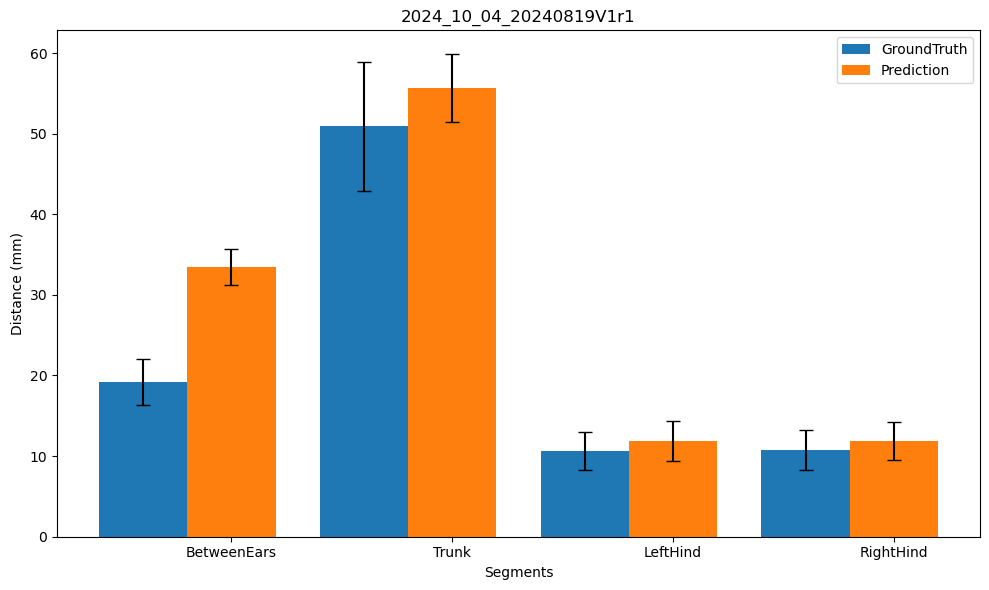

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_20_00/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_20_17



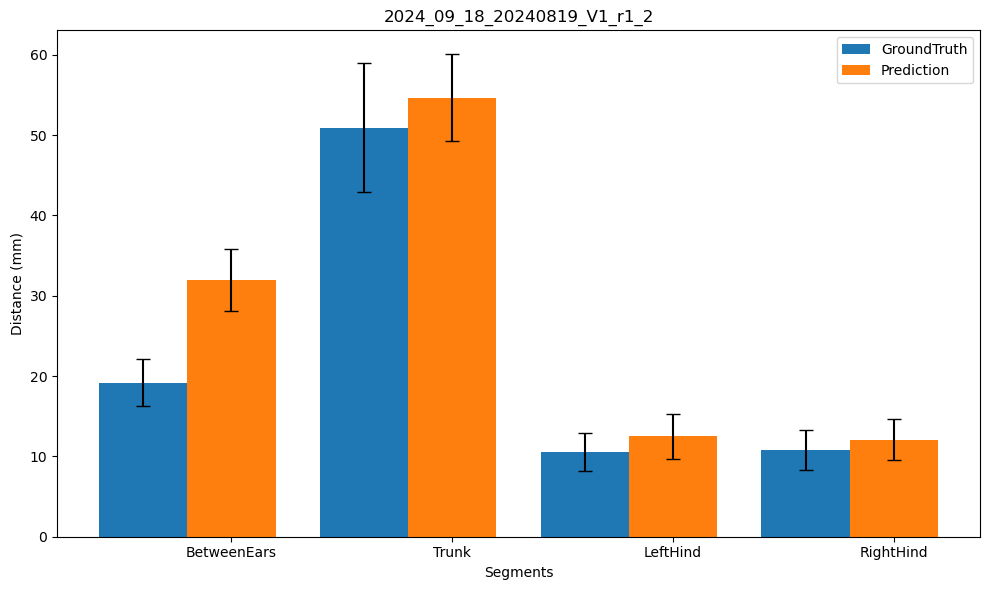

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_20_32
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240916V1r2/DANNCE/predict00/vis/2024_10_04_20240916V1r2.jpg'.


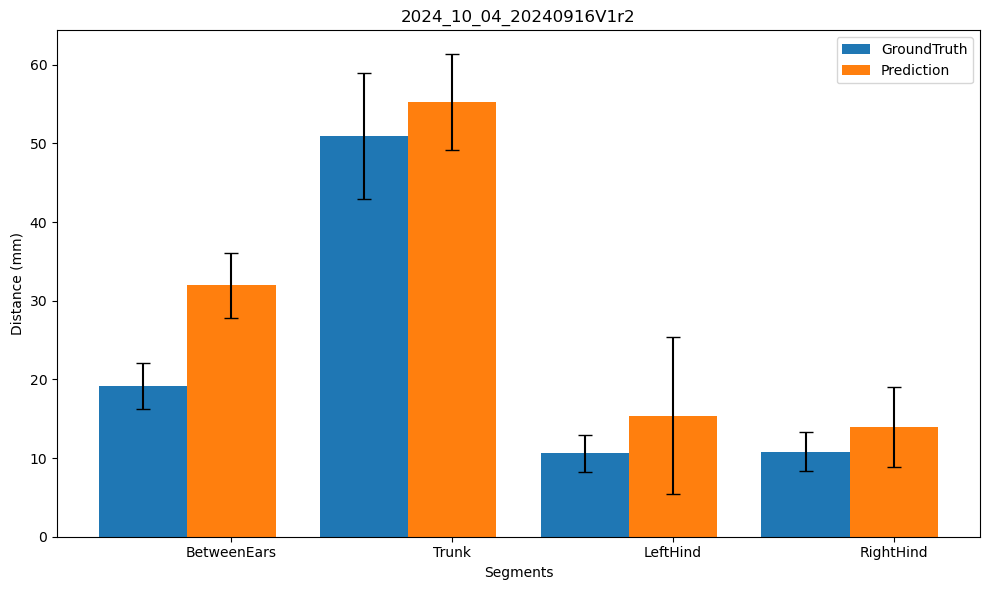

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_14_20
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_04/20240916V1r1/DANNCE/predict00/vis/2024_10_04_20240916V1r1.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_20_17/DANNCE/predict00/vis/2024_10_08_20240819V1r1_20_17.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_20_00/DANNCE/predict00/vis/2024_10_08_20240819V1r1_20_00.jpg'.


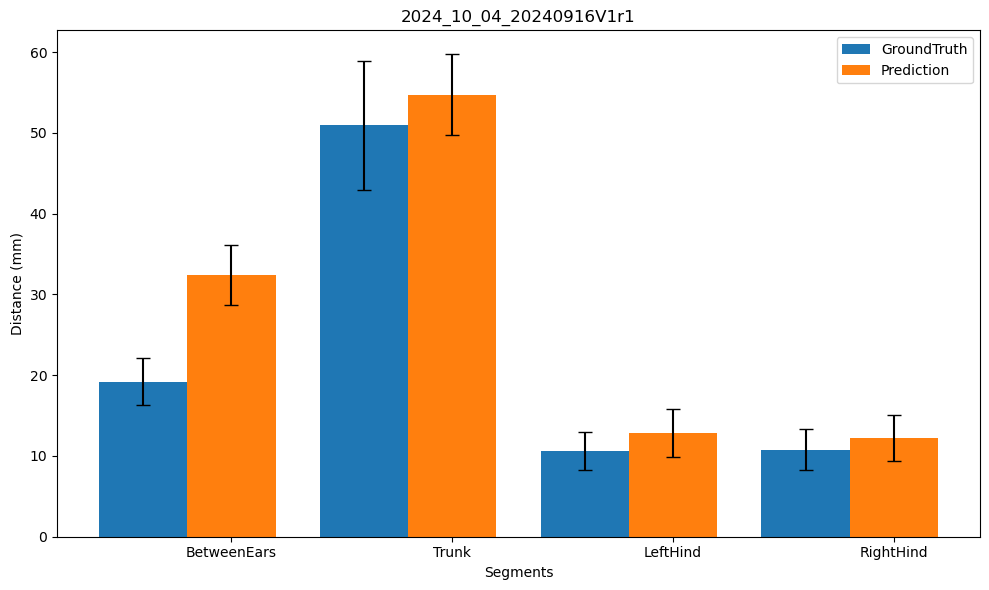

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_14_40
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_19_44/DANNCE/predict00/vis/2024_10_08_20240819V1r1_19_44.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_07/20240916v1r1_17_55/DANNCE/predict00/vis/2024_10_07_20240916v1r1_17_55.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240819V1r1_20_32/DANNCE/predict00/vis/2024_10_08_20240819V1r1_20_32.jpg'.


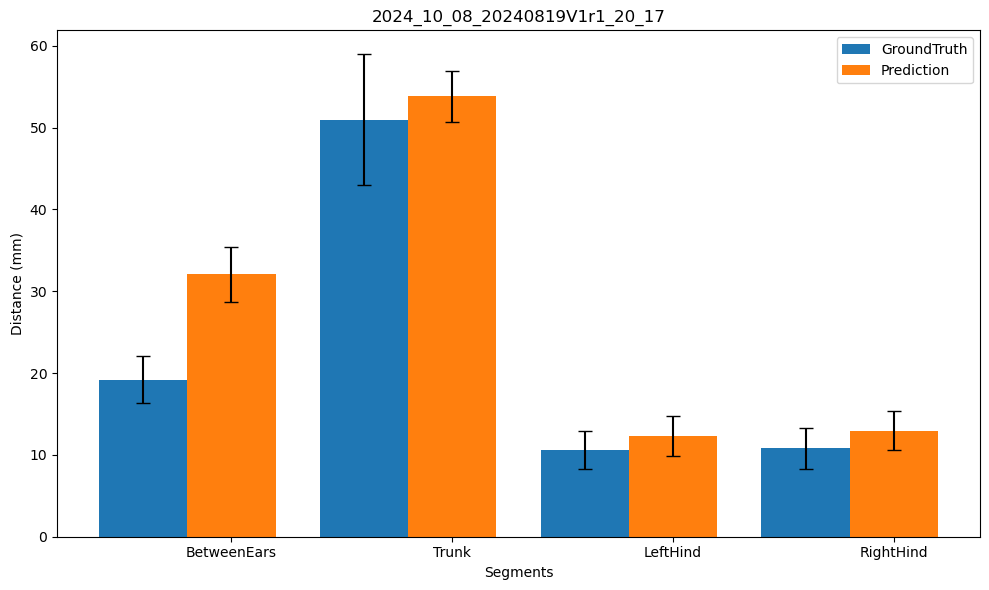

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_15_35


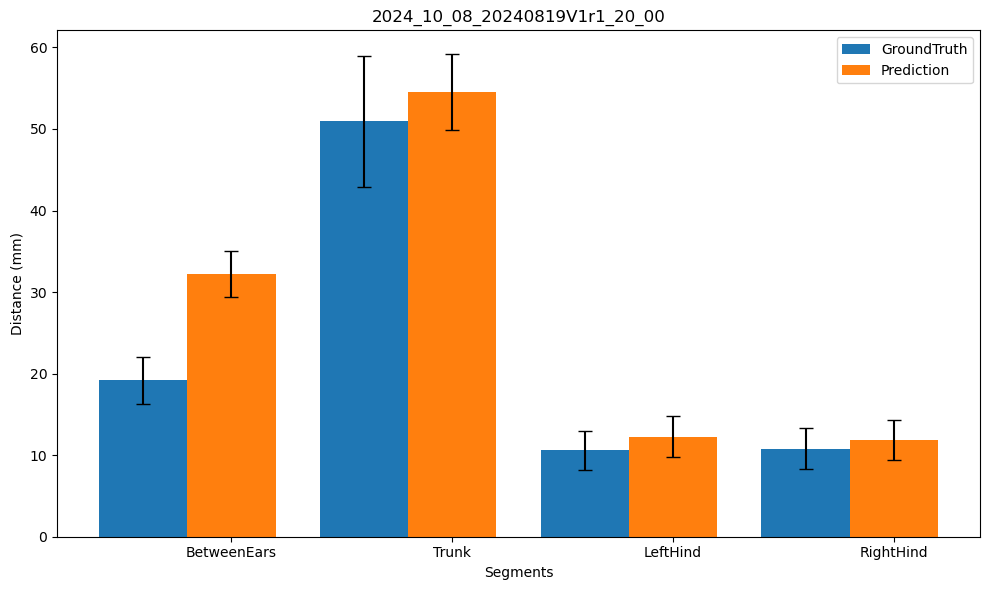

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_16_03


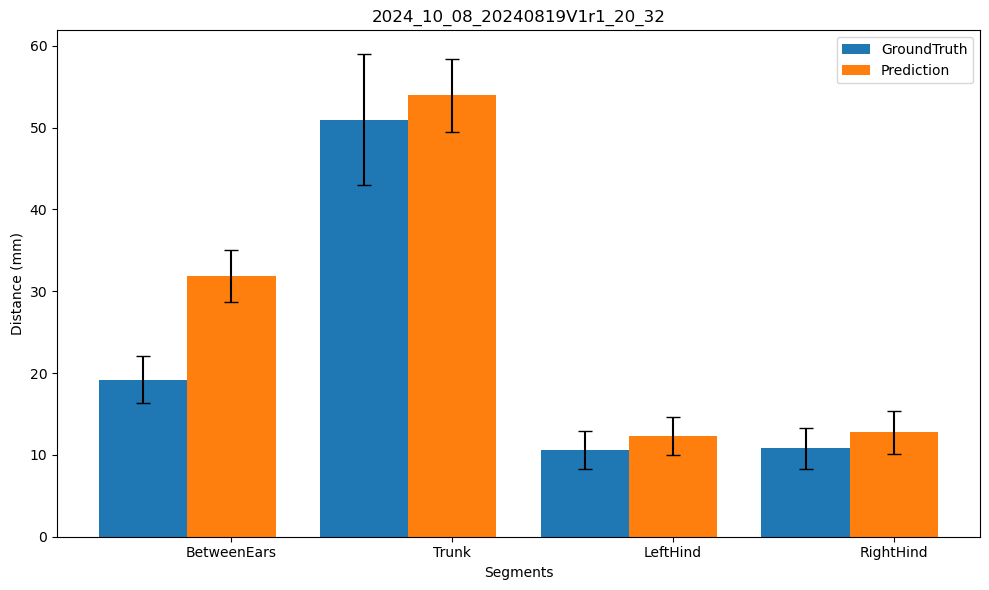

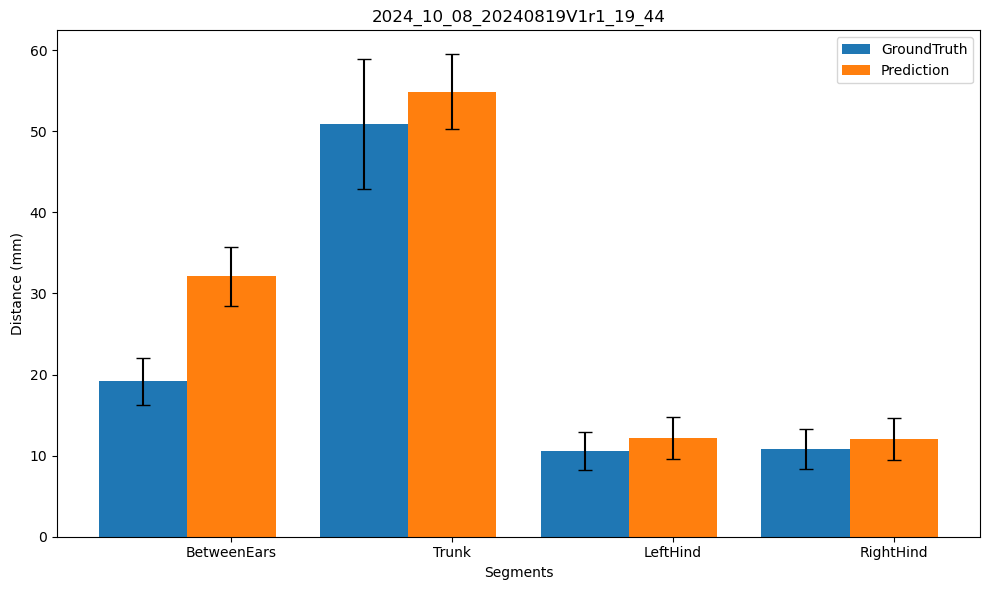

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_16_22/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r1_14_53

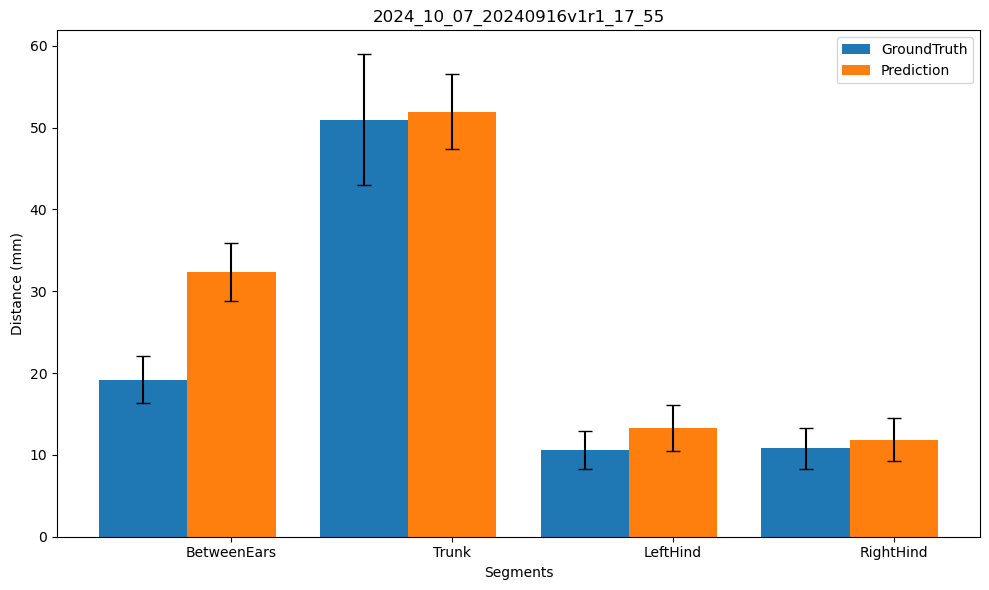


/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r1_16_37

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_14_20/DANNCE/predict00/vis/2024_10_08_20240916v1r1_14_20.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_07/20240916v1r1_15_05_30min/DANNCE/predict00/vis/2024_10_07_20240916v1r1_15_05_30min.jpg'.


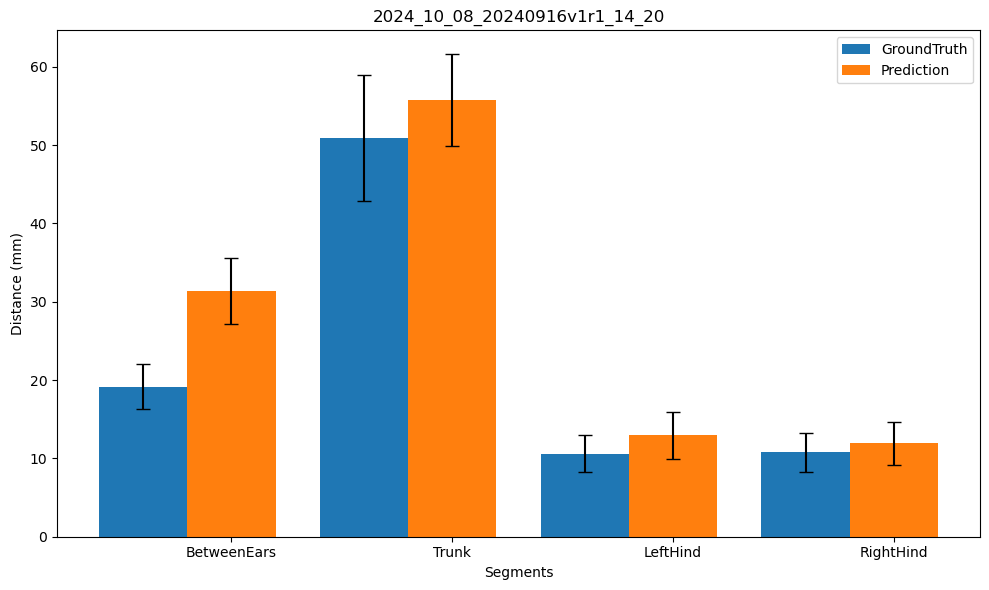

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r1_16_53


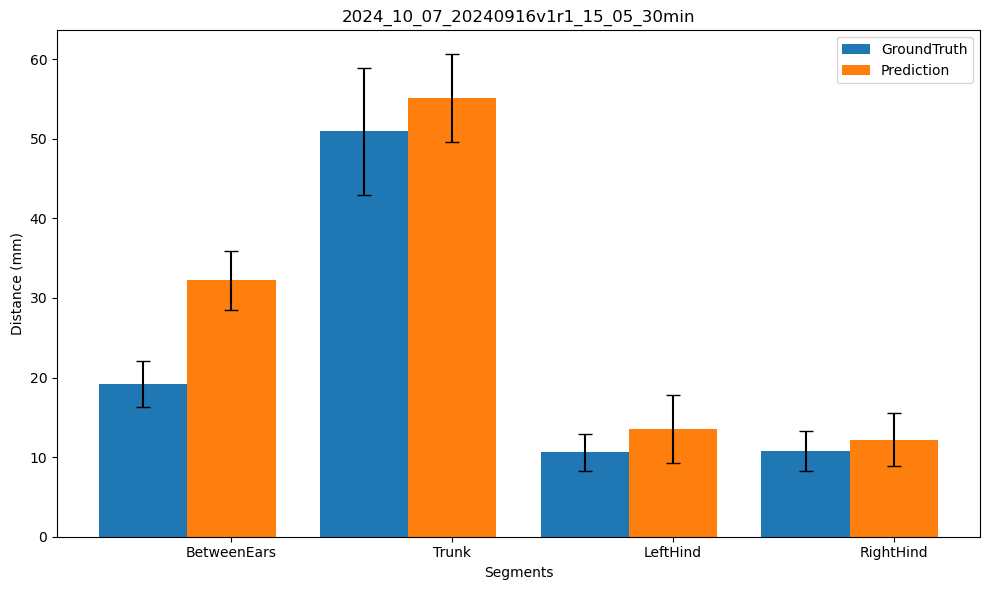

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r2_14_30
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_14_40/DANNCE/predict00/vis/2024_10_08_20240916v1r1_14_40.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_15_35/DANNCE/predict00/vis/2024_10_08_20240916v1r1_15_35.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_16_22/DANNCE/predict00/vis/2024_10_08_20240916v1r1_16_22.jpg'.Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_08/20240916v1r1_16_03/DANNCE/predict00/vis/2024_10_08_20240916v1r1_16_03.jpg'.

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r1_16_37/DANNCE/predict00/vis/2024_10_14_20240916v1r1_16_37.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r1_14_53/DANNCE/predict00/vis/2024_10_14_20240916v1r1_14_53.jpg'.

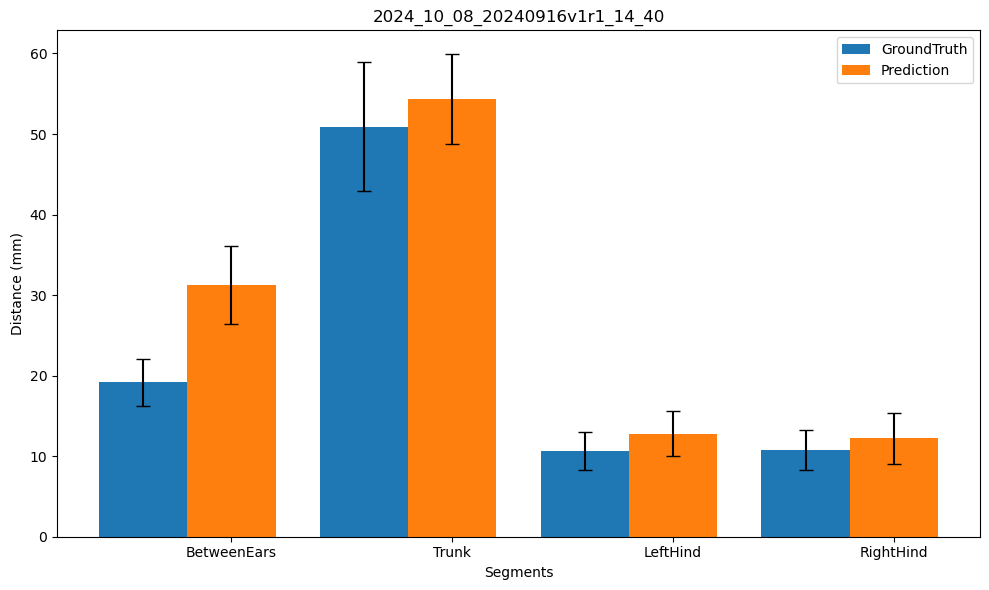

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r2_15_58



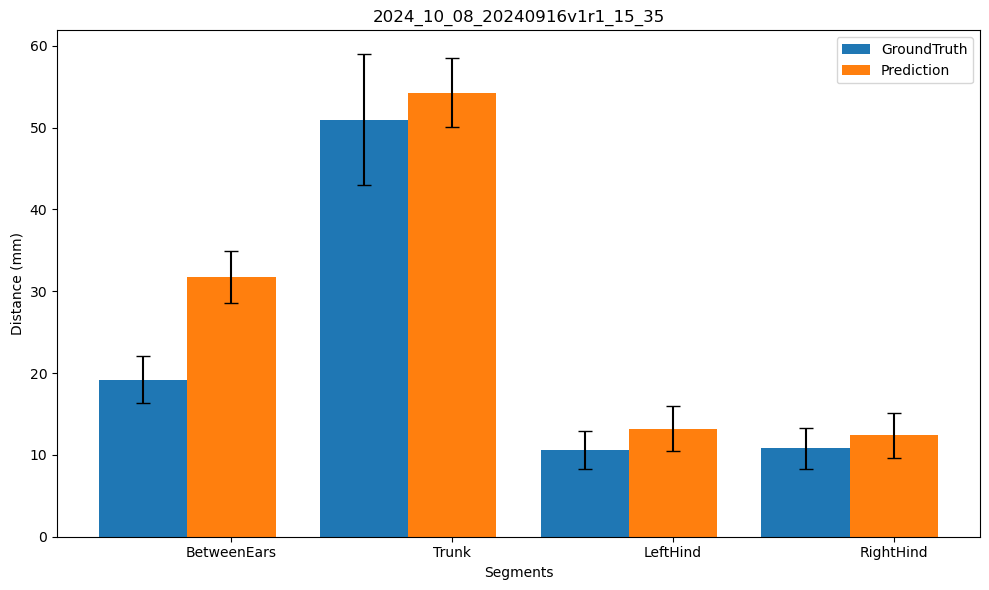

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_17/20240819V1r1_13_41


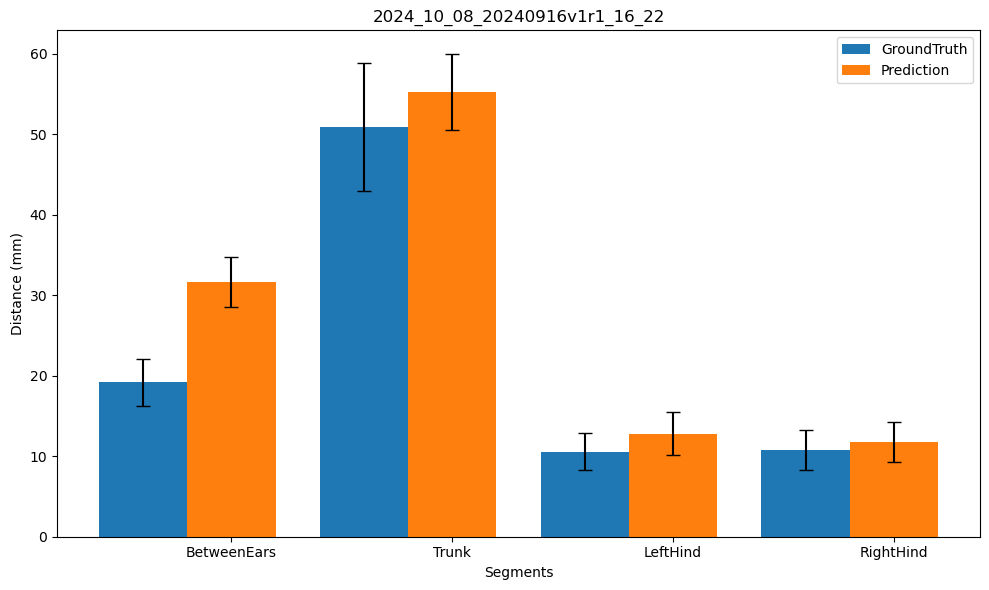

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_17/20240819V1r1_14_25


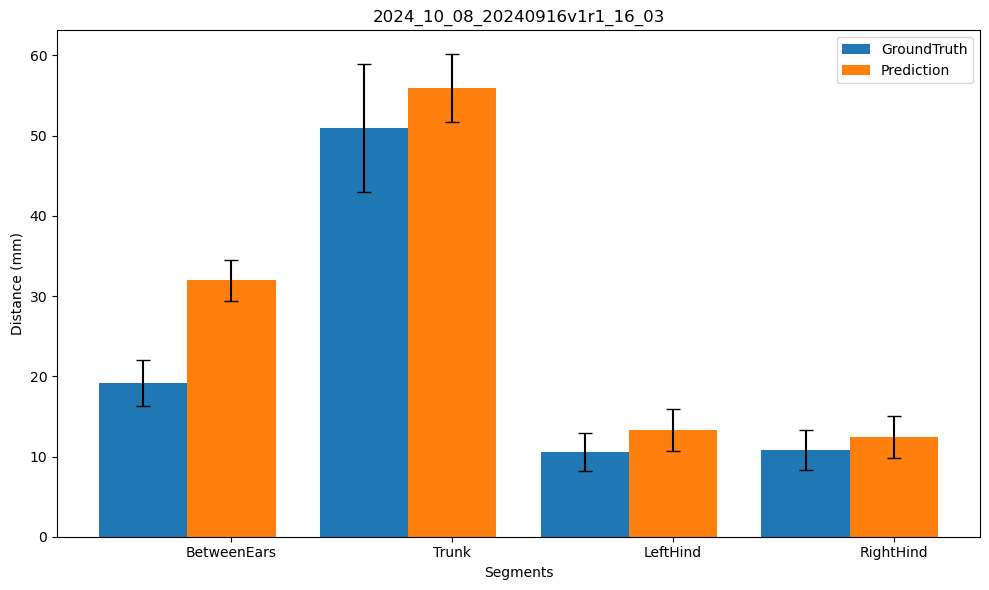

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_17/20240819V1r1_14_40


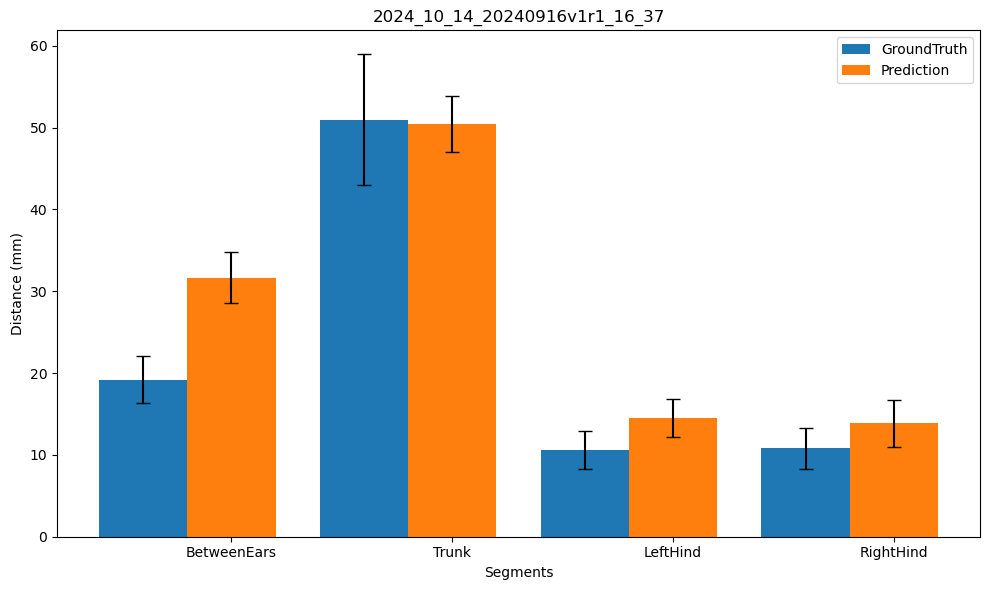

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241001PMCr2_15_07


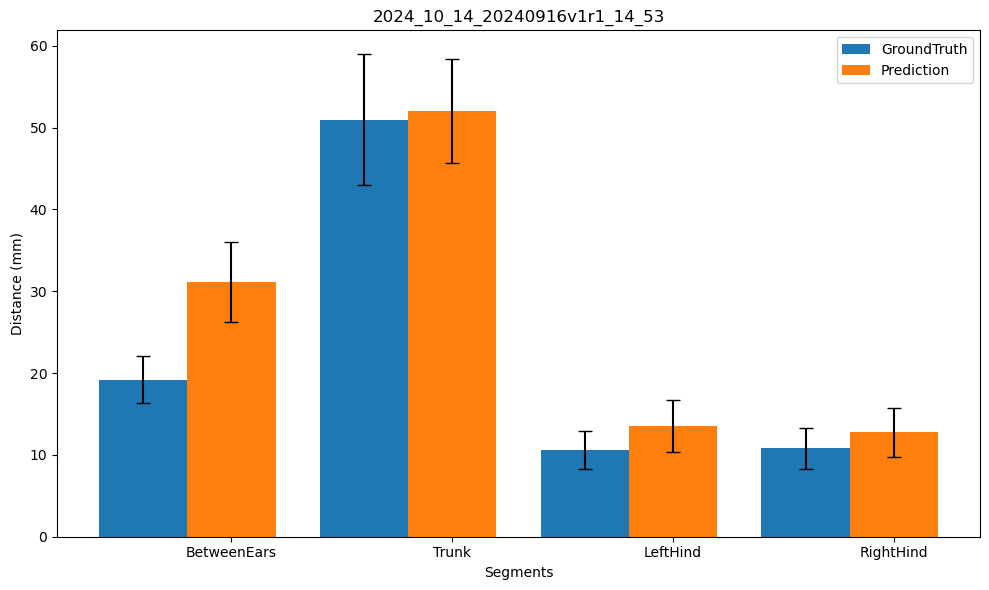

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241001PMCr2_16_19
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r1_16_53/DANNCE/predict00/vis/2024_10_14_20240916v1r1_16_53.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r2_14_30/DANNCE/predict00/vis/2024_10_14_20240916v1r2_14_30.jpg'.


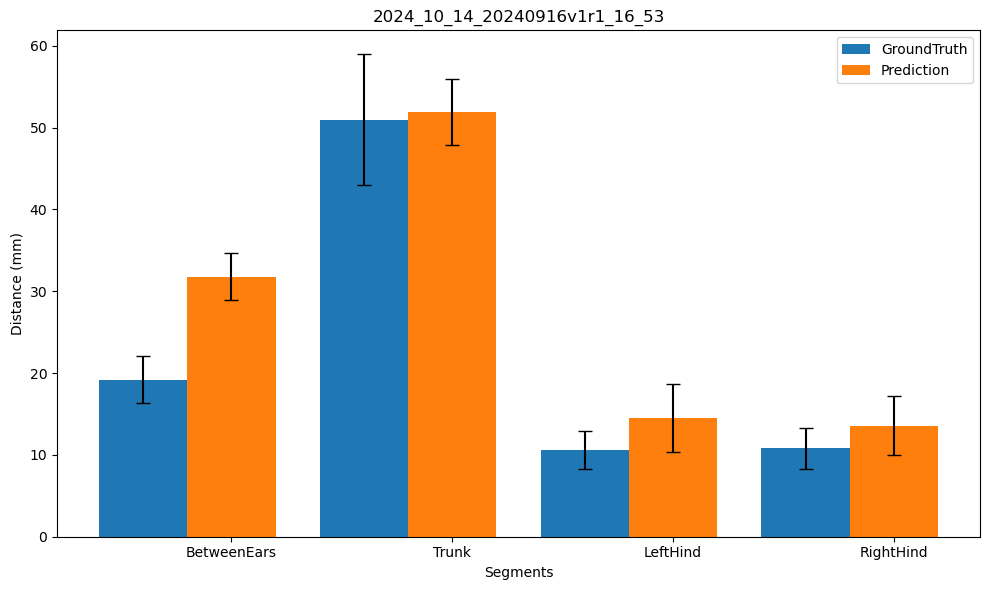

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241002PMCr1_left1_


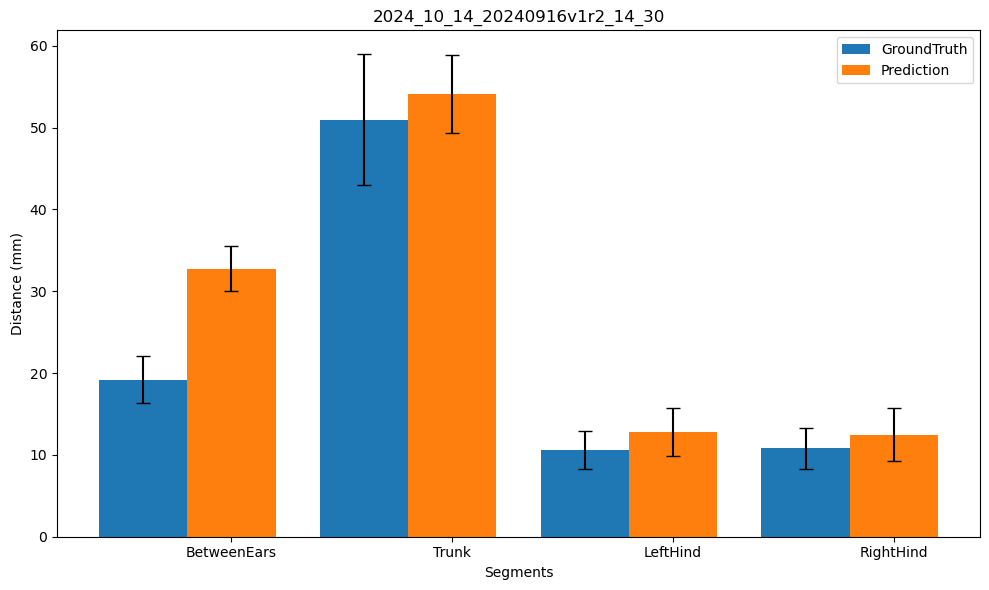

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/202420717PMCr1_
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_14/20240916v1r2_15_58/DANNCE/predict00/vis/2024_10_14_20240916v1r2_15_58.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_17/20240819V1r1_14_25/DANNCE/predict00/vis/2024_10_17_20240819V1r1_14_25.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_17/20240819V1r1_14_40/DANNCE/predict00/vis/2024_10_17_20240819V1r1_14_40.jpg'.


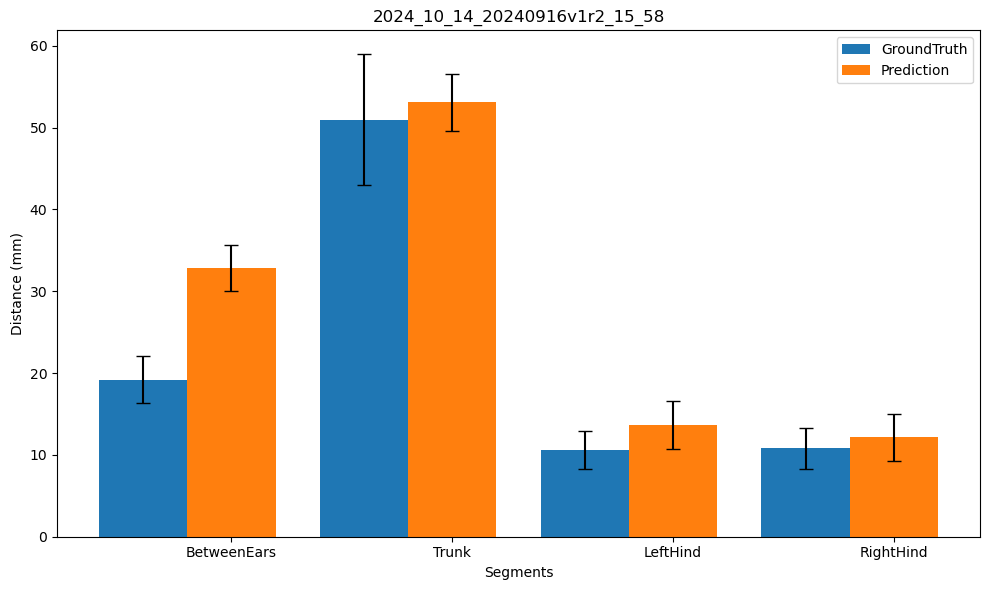

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_17/20240819V1r1_13_41/DANNCE/predict00/vis/2024_10_17_20240819V1r1_13_41.jpg'./hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20240916v1r2_14_30

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241001PMCr2_16_19/DANNCE/predict00/vis/2024_10_24_20241001PMCr2_16_19.jpg'.


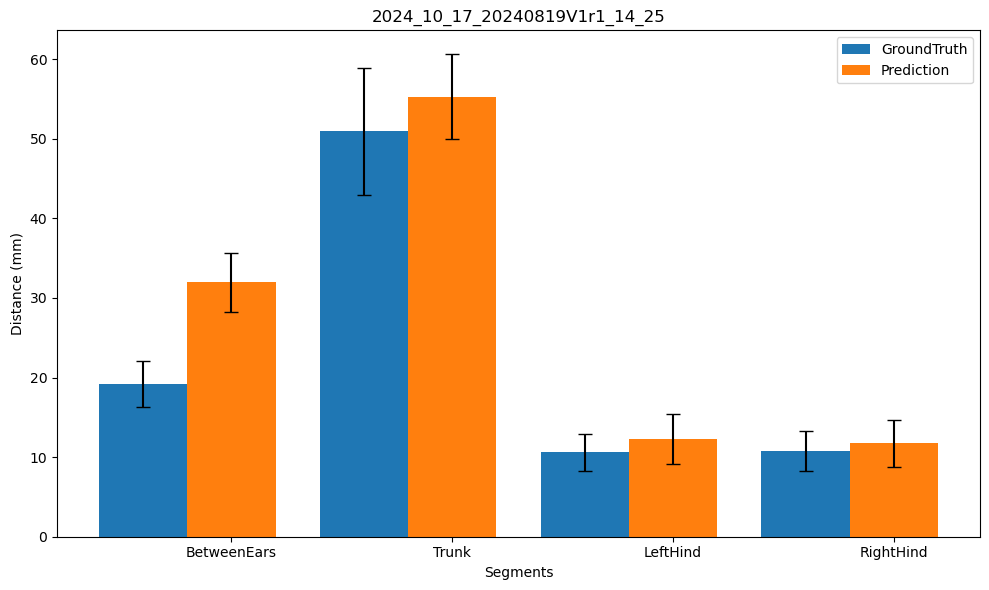

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr1_14_54
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241001PMCr2_15_07/DANNCE/predict00/vis/2024_10_24_20241001PMCr2_15_07.jpg'.


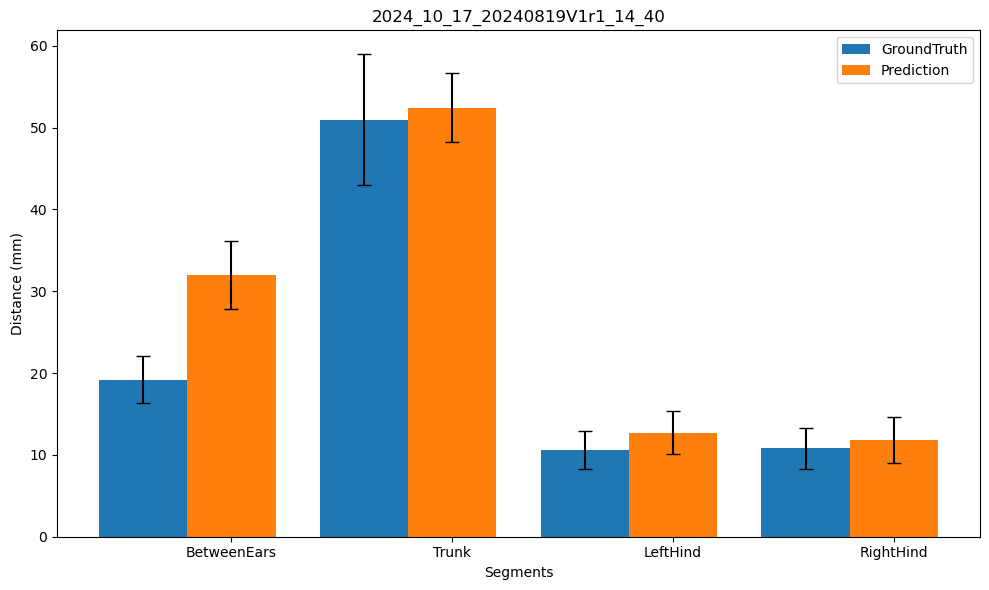

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr2_15_42


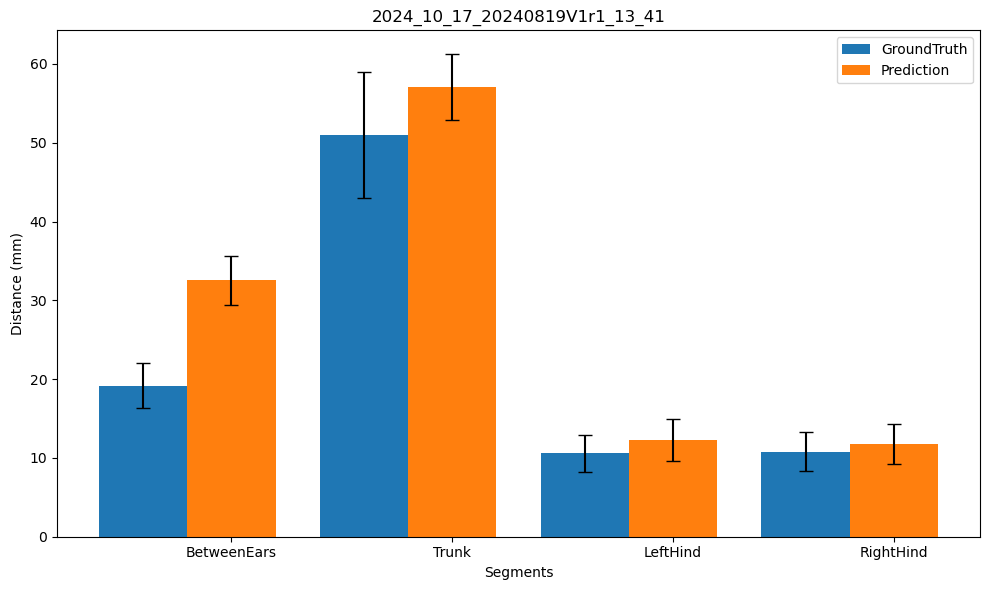

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr2_16_25


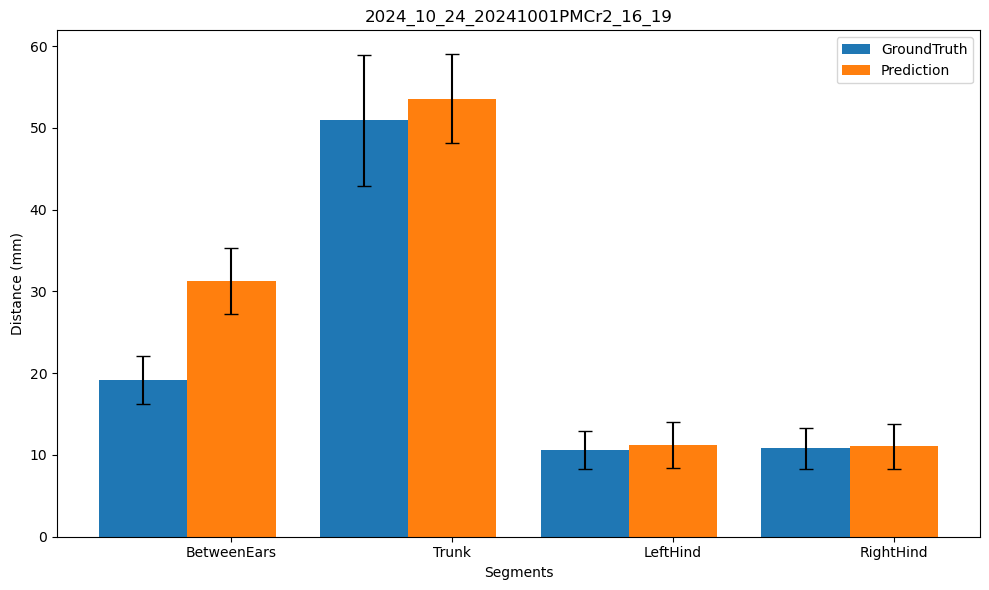

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr2_17_05


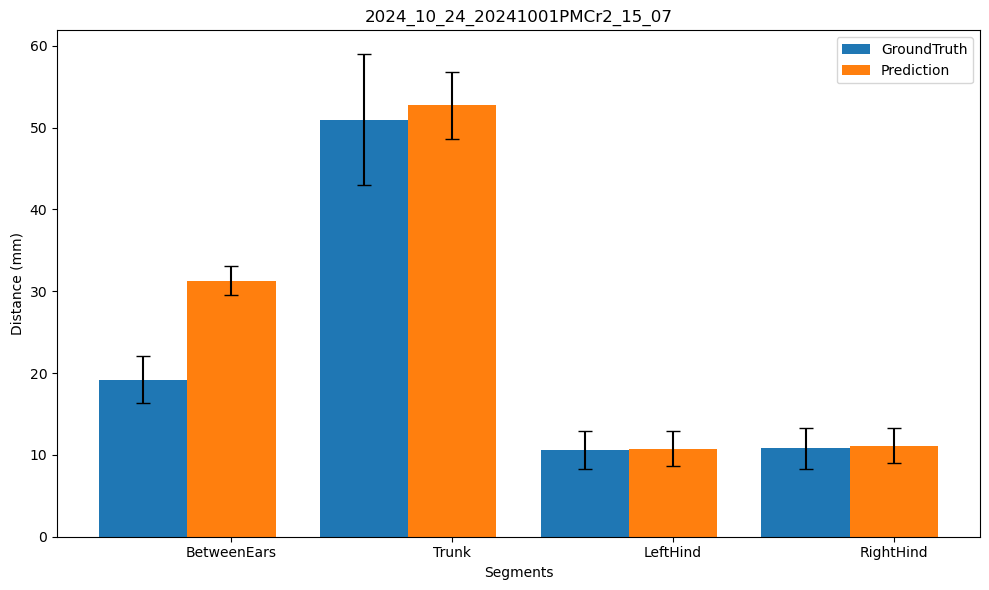

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240819V1r1_AO_14_56
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/20241002PMCr1_left1_/DANNCE/predict00/vis/2024_10_24_20241002PMCr1_left1_.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_24/202420717PMCr1_/DANNCE/predict00/vis/2024_10_24_202420717PMCr1_.jpg'.


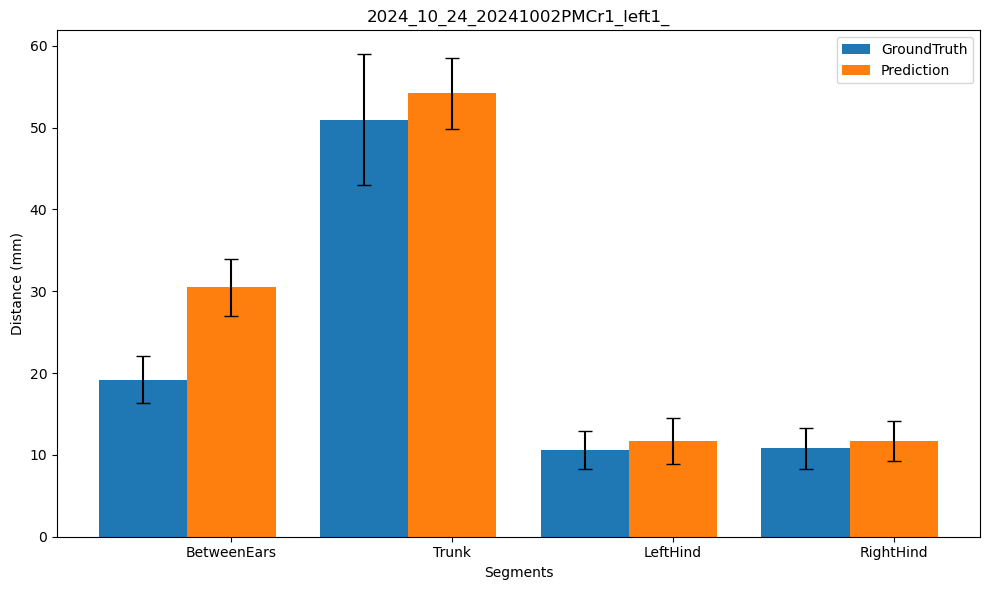

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_AO_12_50


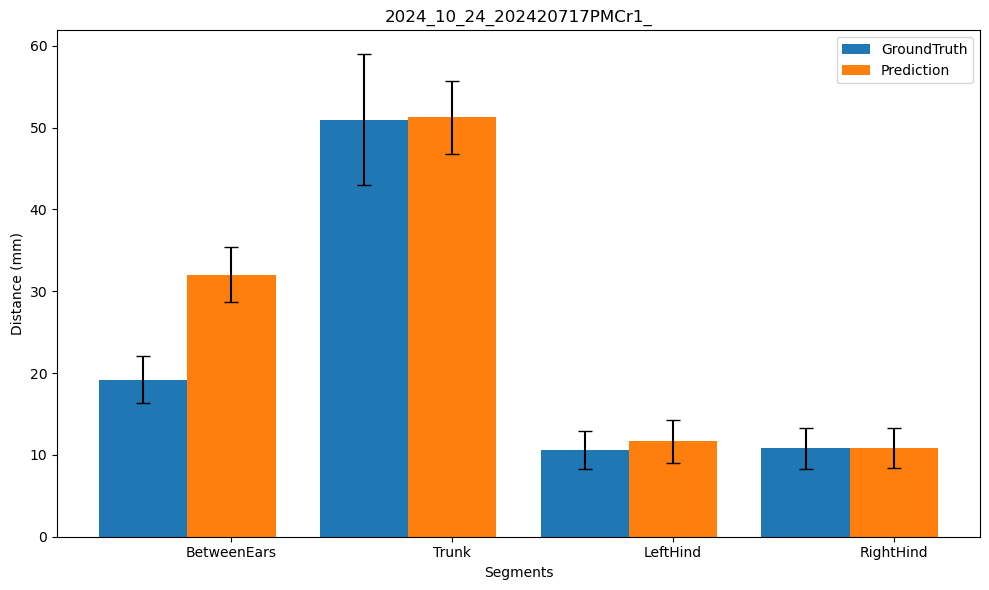

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr1_14_54/DANNCE/predict00/vis/2024_10_25_20241002PMCr1_14_54.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr2_15_42/DANNCE/predict00/vis/2024_10_25_20241002PMCr2_15_42.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20240916v1r2_14_30/DANNCE/predict00/vis/2024_10_25_20240916v1r2_14_30.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr2_16_25/DANNCE/predict00/vis/2024_10_25_20241002PMCr2_16_25.jpg'.


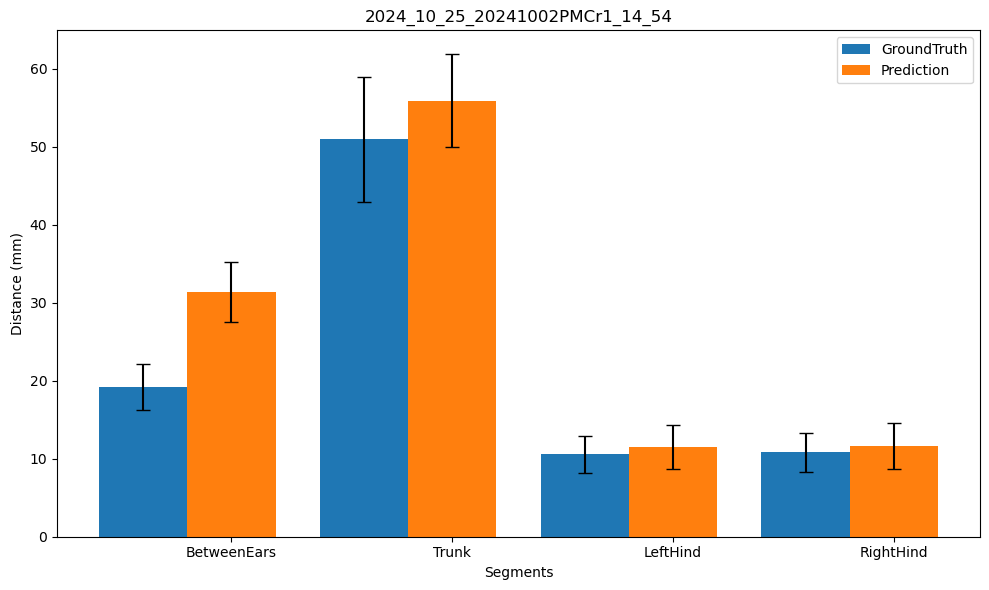

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/DANNCE/predict00/vis/2024_11_01_20240819V1r1_AO_14_56.jpg'.

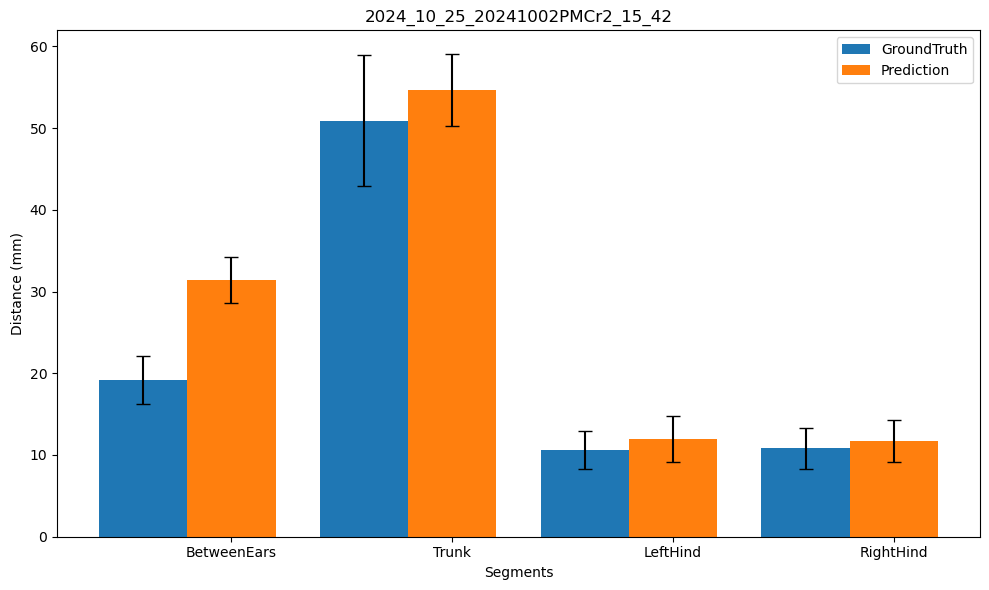


/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_1


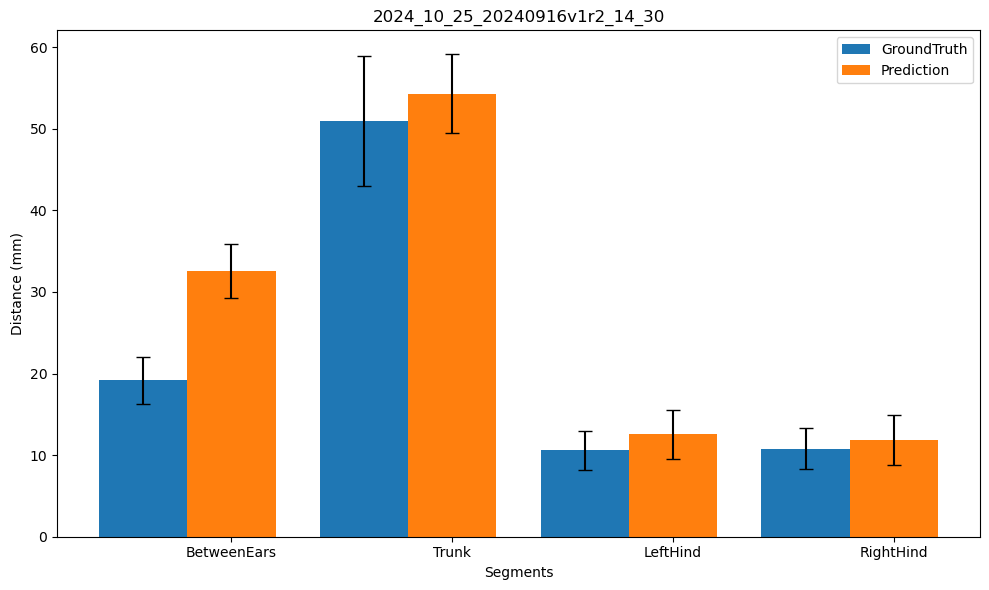

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_2_14_00
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_10_25/20241002PMCr2_17_05/DANNCE/predict00/vis/2024_10_25_20241002PMCr2_17_05.jpg'.


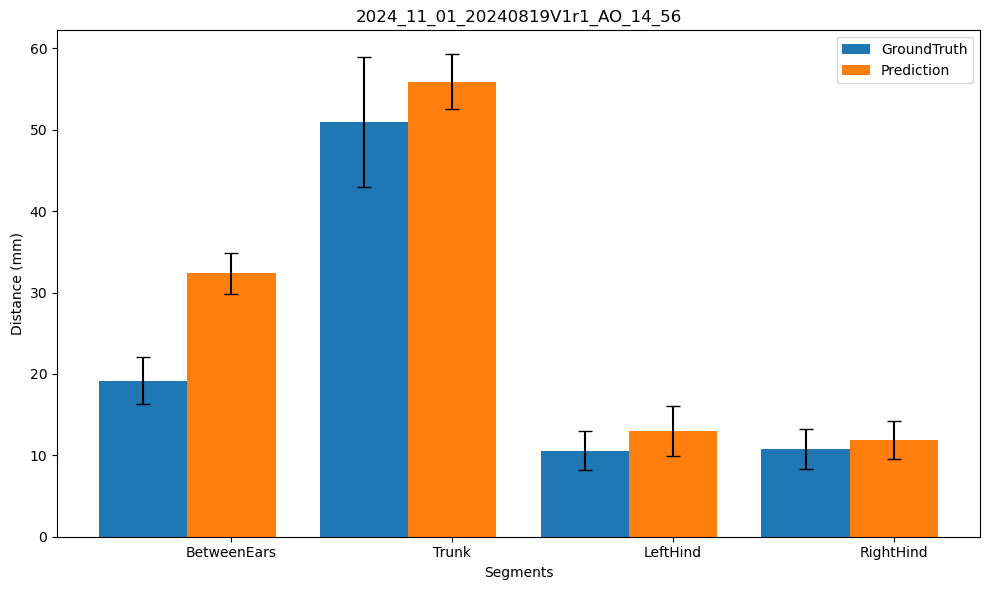

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_3_14_32Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_AO_12_50/DANNCE/predict00/vis/2024_11_01_20240910V1r_AO_12_50.jpg'.

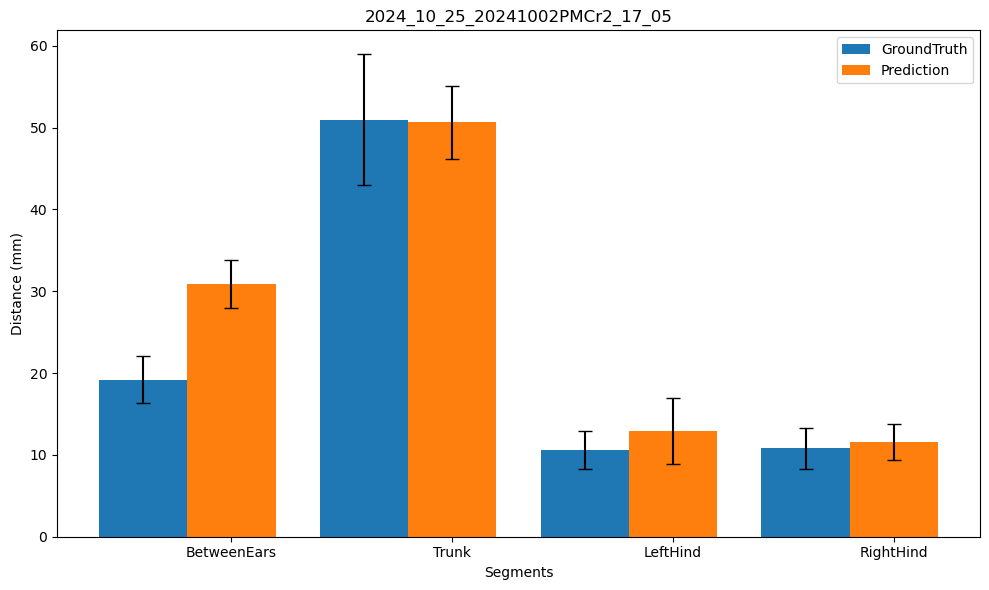


/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_all_dead_3_14_50

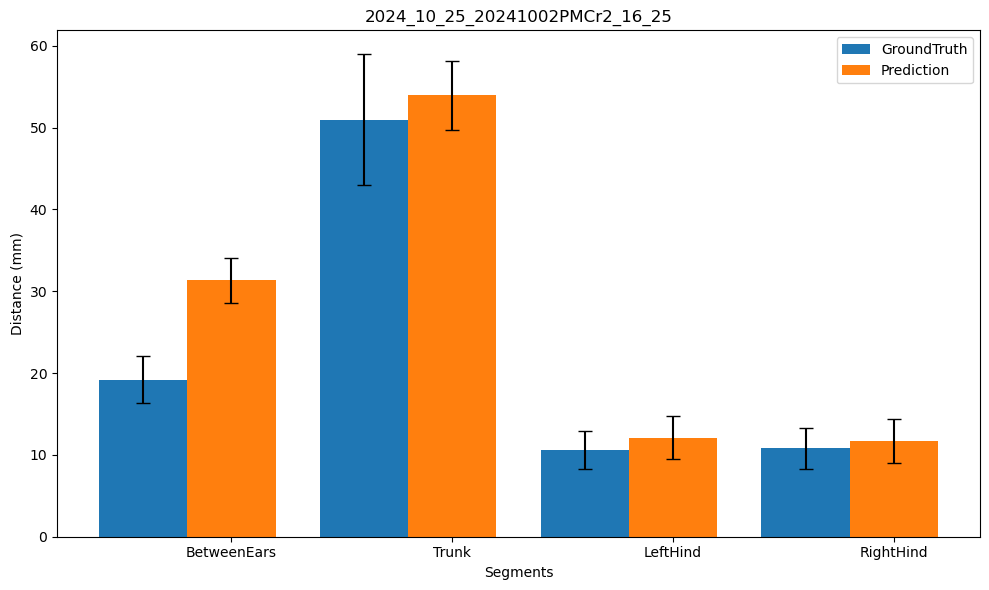

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/20241015pmcr1_16_12


Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35/DANNCE/predict00/vis/2024_11_01_20240910V1r_BO_11_35.jpg'.


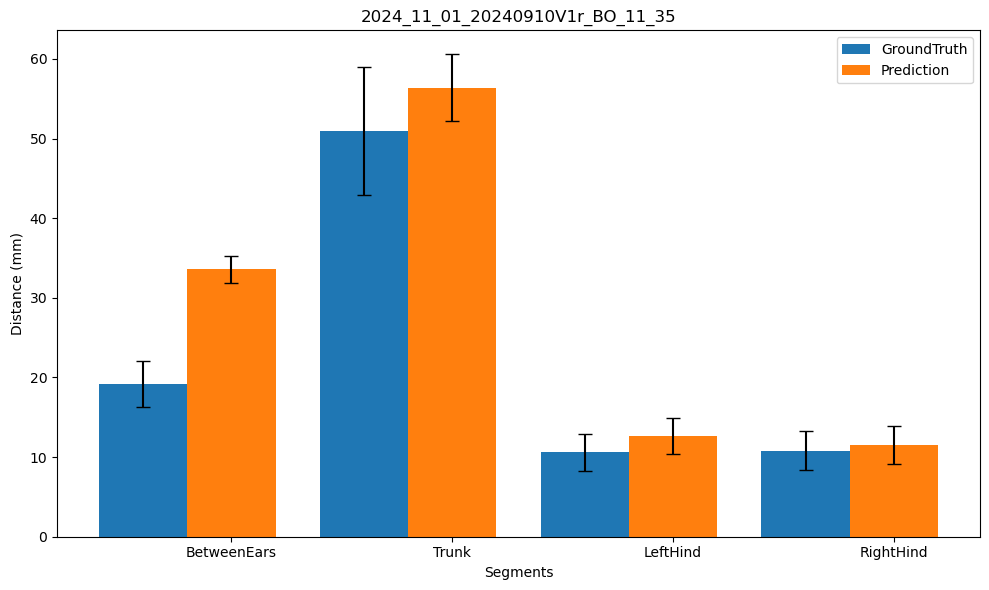

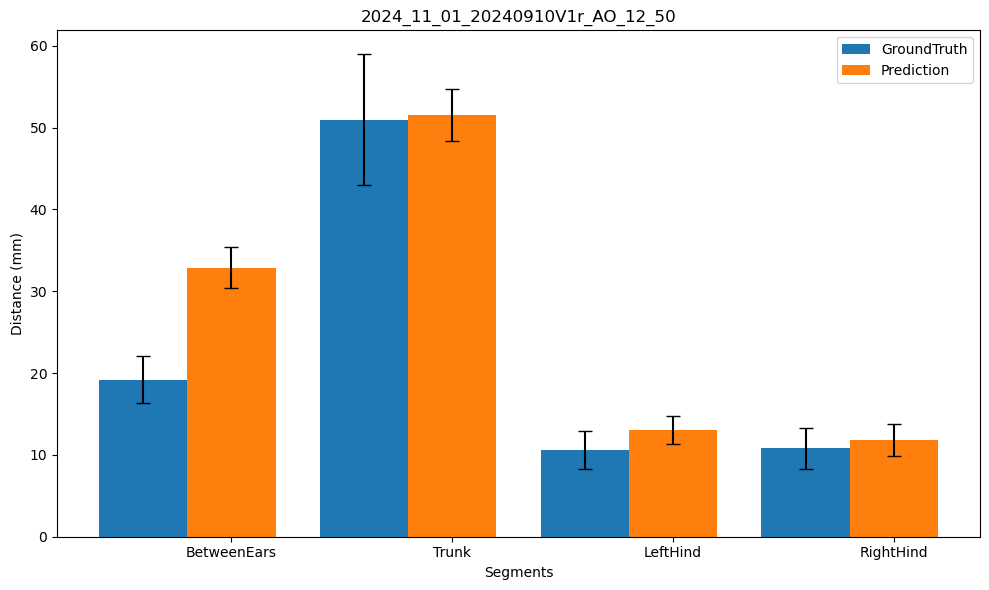

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/20241015pmcr2_17_13/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/20241015pmcr2_16_53

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50/DANNCE/predict00/vis/2024_11_01_2social_mini_20240910V1r_AO_single_12_50.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_1/DANNCE/predict00/vis/2024_11_06_0cricket_test_1.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_2_14_00/DANNCE/predict00/vis/2024_11_06_0cricket_test_2_14_00.jpg'.


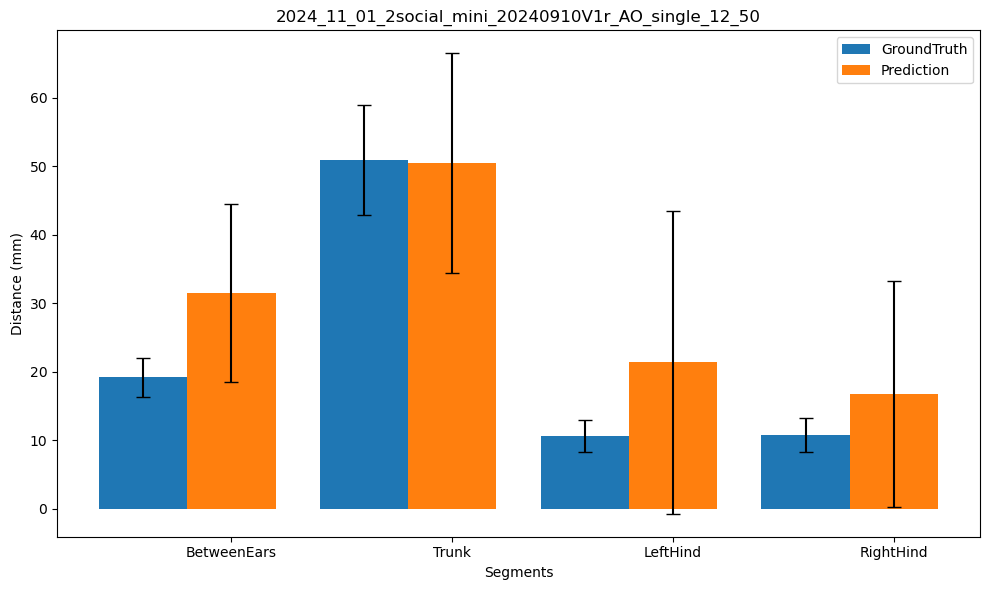

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52


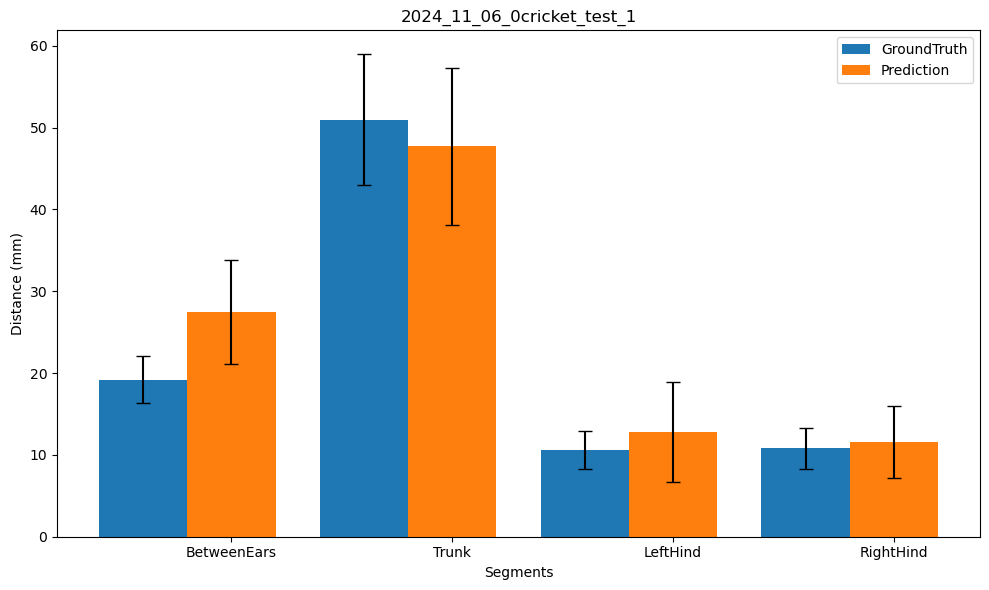

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17


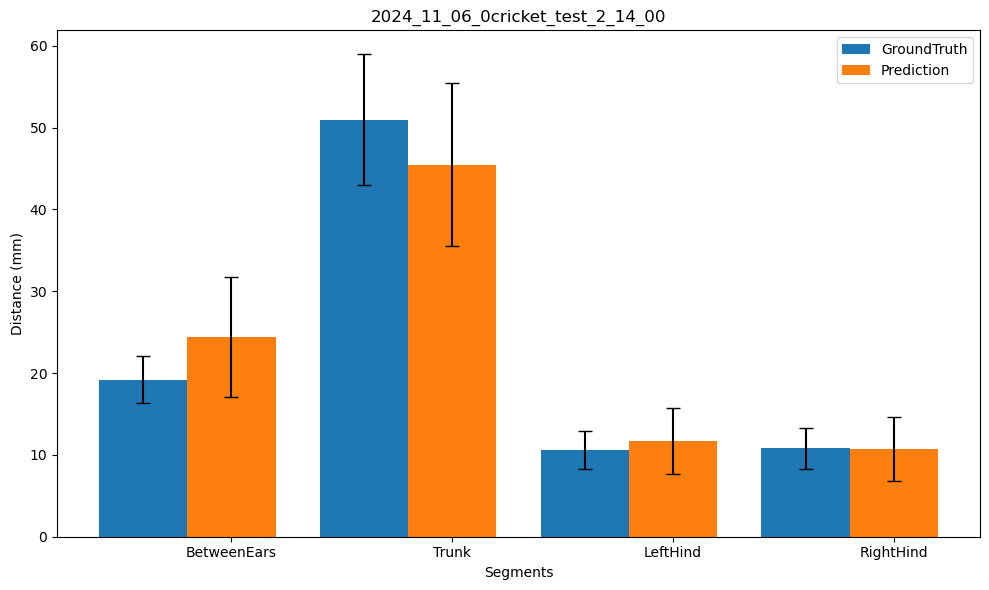

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_all_dead_3_14_50/DANNCE/predict00/vis/2024_11_06_0cricket_test_all_dead_3_14_50.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/20241015pmcr1_16_12/DANNCE/predict00/vis/2024_11_06_20241015pmcr1_16_12.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/0cricket_test_3_14_32/DANNCE/predict00/vis/2024_11_06_0cricket_test_3_14_32.jpg'.


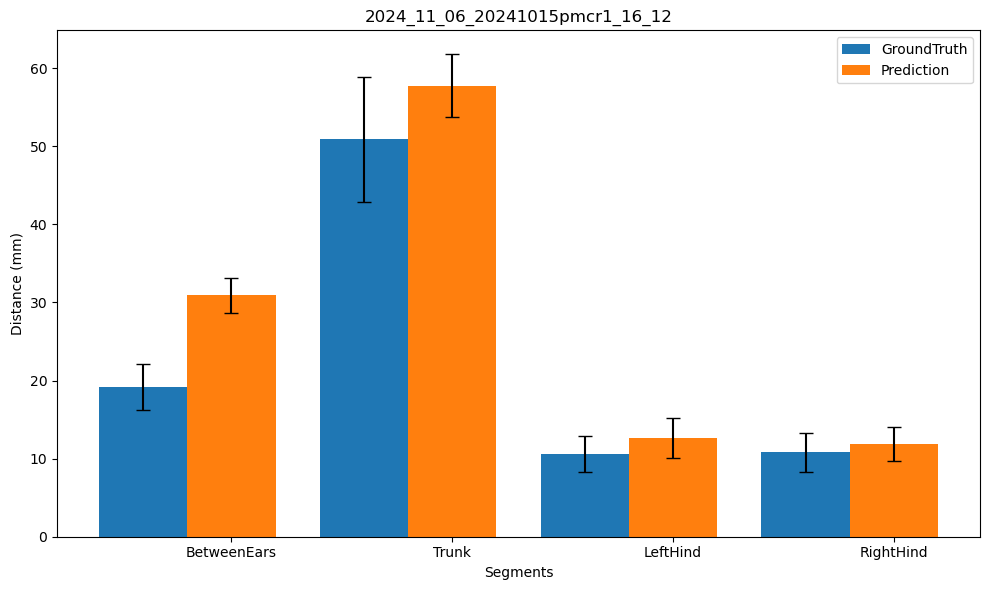

/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05


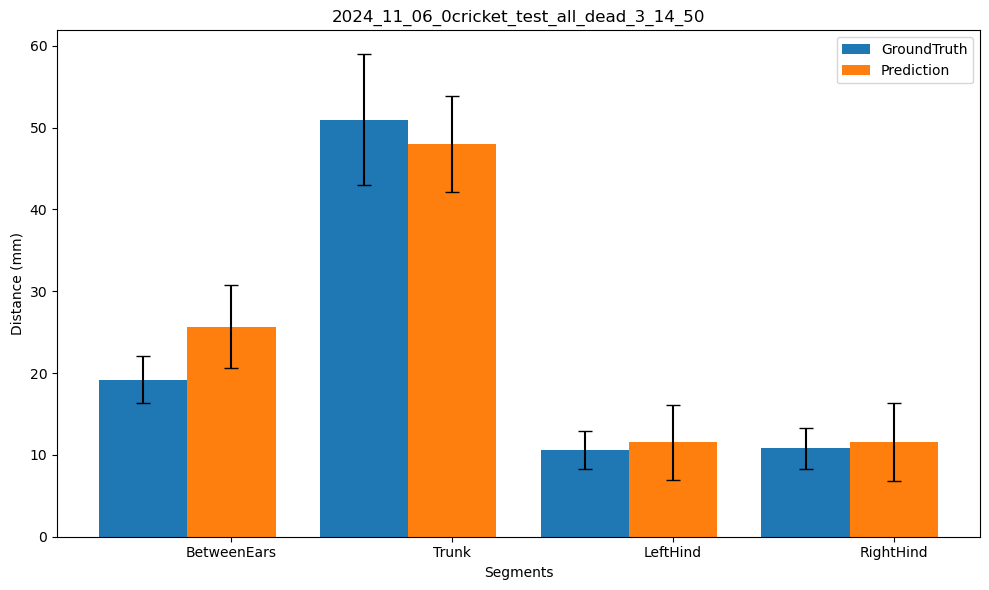

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/20241015pmcr2_17_13/DANNCE/predict00/vis/2024_11_06_20241015pmcr2_17_13.jpg'.
Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_06/20241015pmcr2_16_53/DANNCE/predict00/vis/2024_11_06_20241015pmcr2_16_53.jpg'.


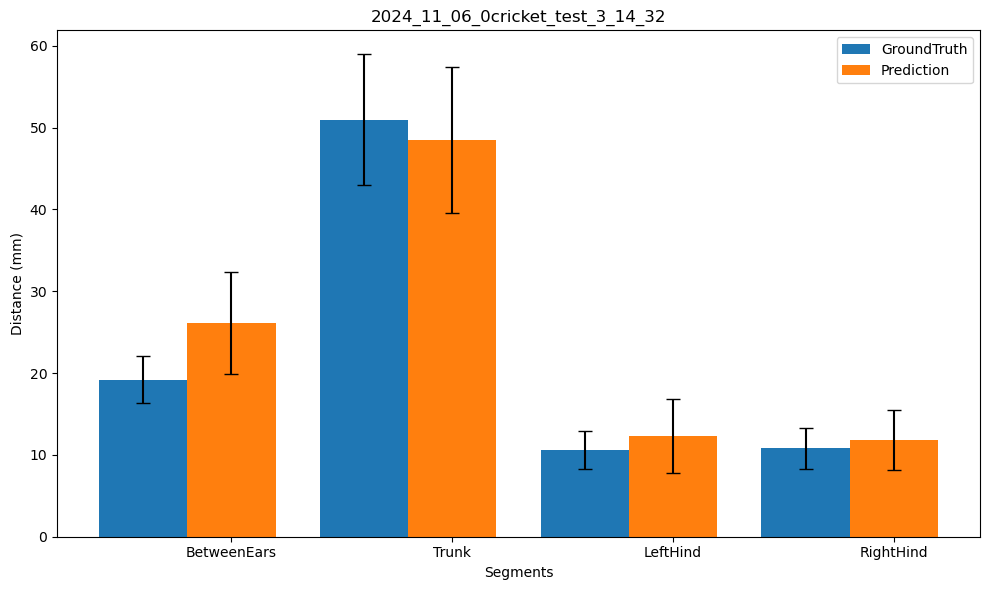

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_acrylic_test_14_55/DANNCE/predict00/vis/2024_11_13_240605pmc_righthole_acrylic_test_14_55.jpg'.


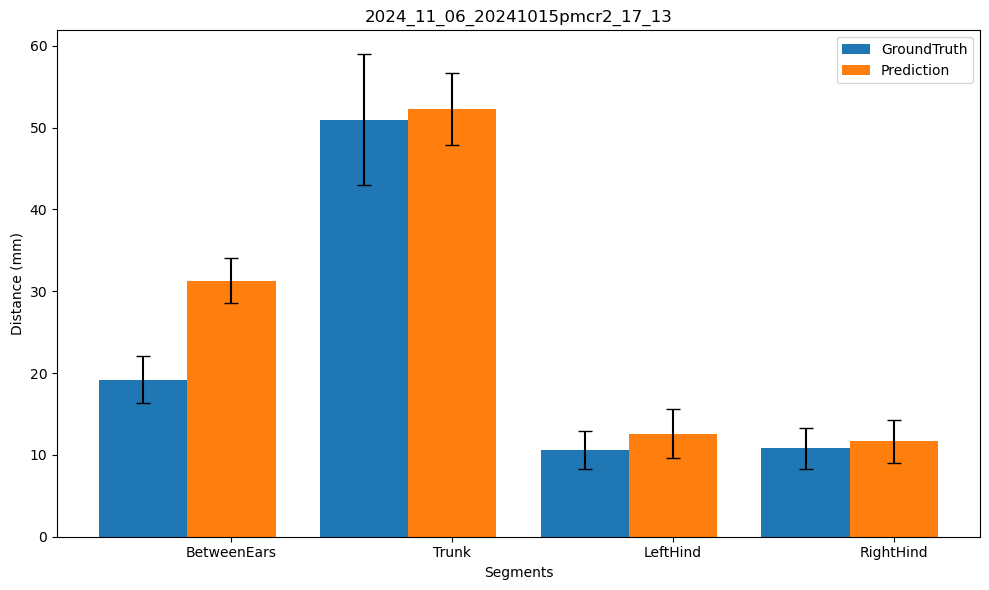

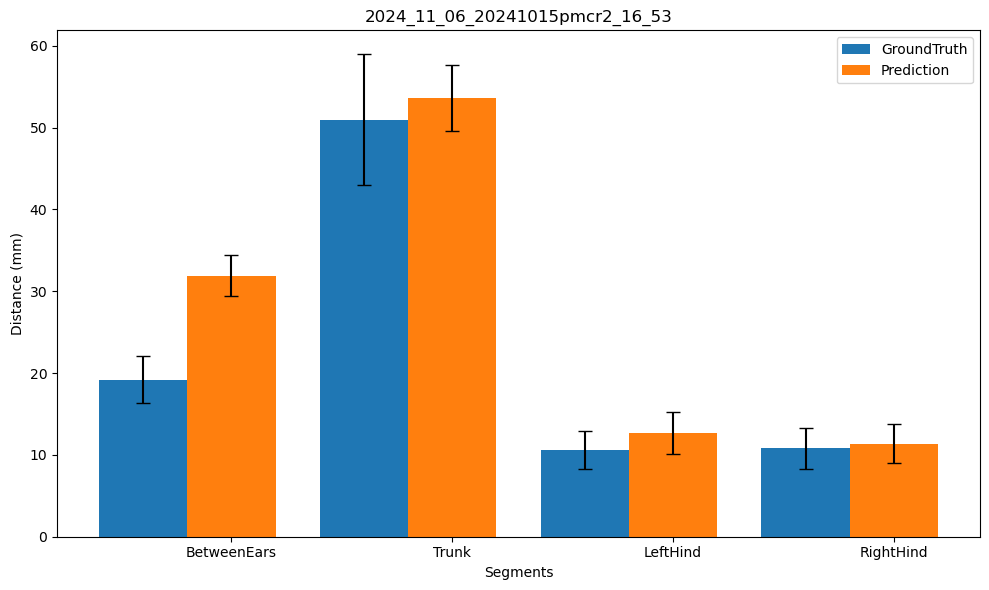

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52/DANNCE/predict00/vis/2024_11_07_20241015pmcr2_AO_12_52.jpg'.


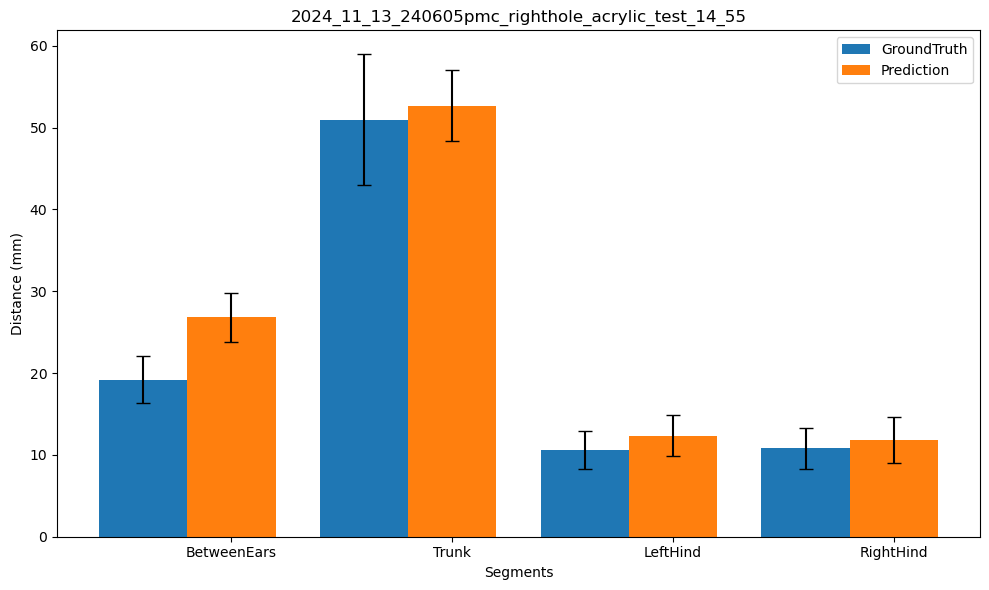

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17/DANNCE/predict00/vis/2024_11_13_20240910v1r_cricket_cyliner_test_16_17.jpg'.


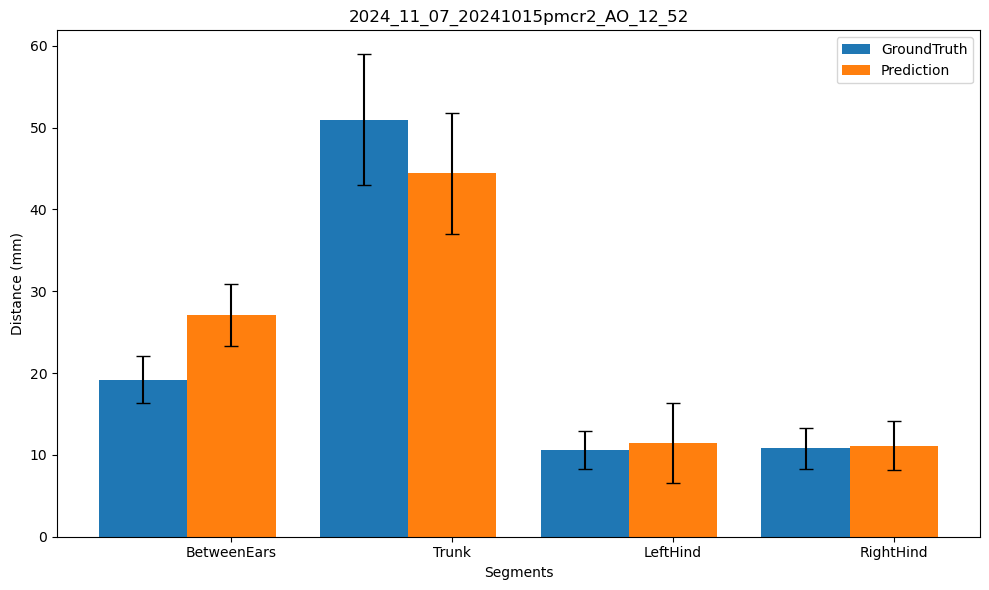

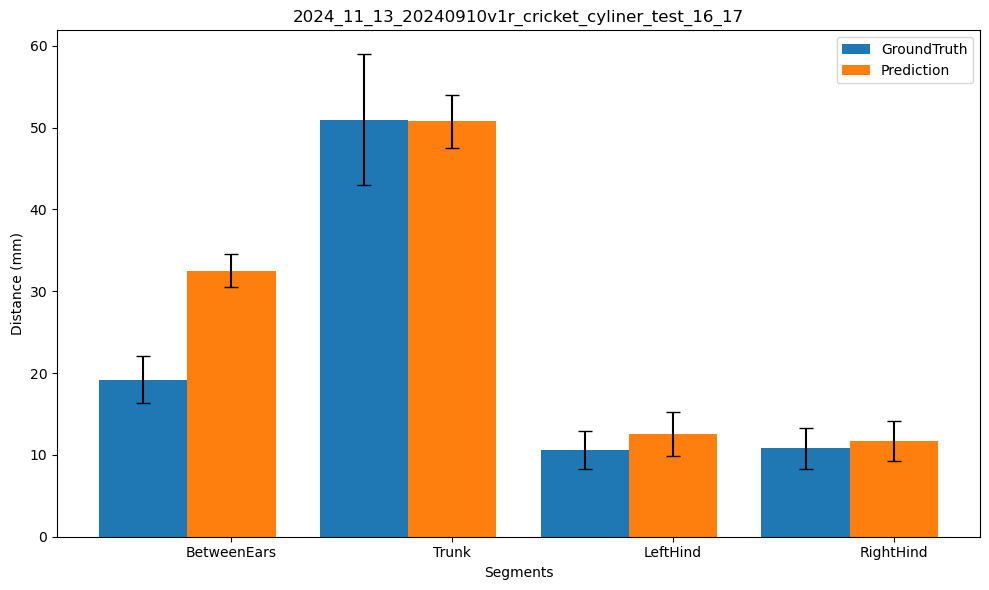

Plot saved as '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/240605pmc_righthole_cricket_acrylic_test_15_05/DANNCE/predict00/vis/2024_11_13_240605pmc_righthole_cricket_acrylic_test_15_05.jpg'.


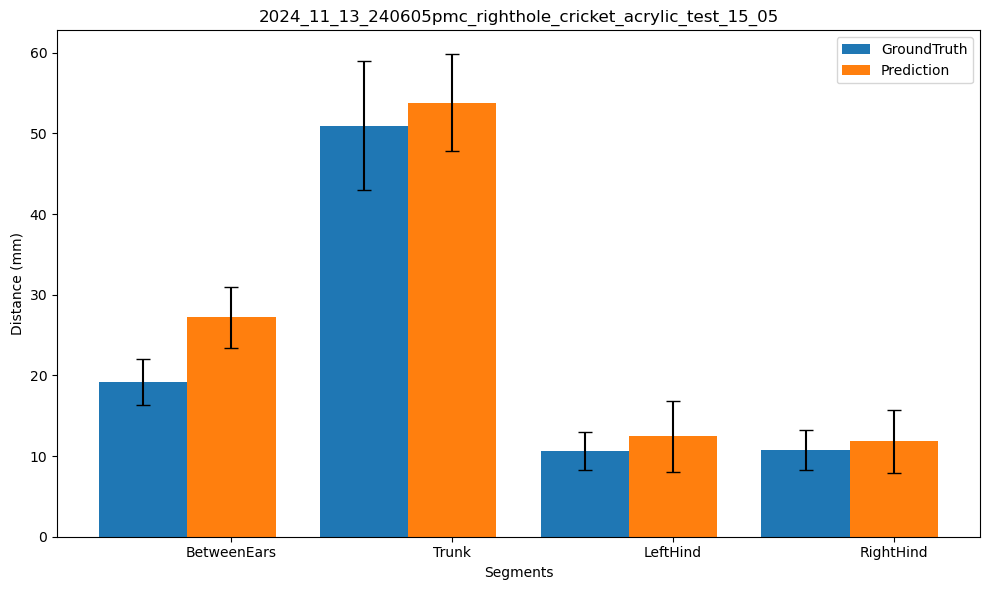

In [ ]:
from useful_files.sophie_check_dannce_mir_modif import dannce_valid
records = [
    {
        'date_folder': date_folder.as_py(),  # Convert to string using as_py()
        'rec_file': rec_file.as_py()         # Convert to string using as_py()
    }
    for date_folder, rec_file in zip(for_dannce_vis['date_folder'], for_dannce_vis['rec_file'])
]

# Iterate through the records and process each one sequentially
# for record in records:
#     base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
#     print(base_path)
#     try:
#         dannce_valid(base_path) #com_folder_name='COM/predict00', perform_jump_indices=True, perform_video_generation=False, perform_generate_com_video=False
#     except Exception as e:
#         print(f"An error occurred while processing {base_path}: {e}")
#         # Skip to the next record if an error occurs
#         continue

#trying for parallel processing again:
from concurrent.futures import ProcessPoolExecutor, as_completed

def process_record(record):
    base_path = f"{base_folder}/{record['date_folder']}/{record['rec_file']}"
    print(base_path)
    try:
        dannce_valid(base_path)
    except Exception as e:
        print(f"An error occurred while processing {base_path}: {e}")
        # Skip to the next record if an error occurs
        pass

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_record, record) for record in records]
    for future in as_completed(futures):
        pass  # You can retrieve results or handle exceptions here if needed
